<a href="https://colab.research.google.com/github/joshsalako/semeval/blob/main/polar_hausa_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POLAR Subtask 1: Hausa-English Implementation

This notebook implements the polarization detection task (Subtask 1) for both English and Hausa languages

In [ ]:
model_name = "castorini/afriteva_base" #@param
#"Davlan/afro-xlmr-large" # "microsoft/mdeberta-v3-base" Tadesse/AfroXLMR-Social

## Setup and Imports

In [ ]:
! pip install emoji
! pip install peft accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import math
import re
from wordcloud import WordCloud
import io
import emoji
import shutil
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import wandb
from google.colab import drive, files
from peft import LoraConfig, get_peft_model

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/polar/dev_phase.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/polar/dev_phase.zip
   creating: subtask1/
   creating: subtask1/dev/
  inflating: subtask1/dev/nep.csv    
  inflating: subtask1/dev/ita.csv    
  inflating: subtask1/dev/pol.csv    
  inflating: subtask1/dev/rus.csv    
  inflating: subtask1/dev/tel.csv    
  inflating: subtask1/dev/hin.csv    
  inflating: subtask1/dev/hau.csv    
  inflating: subtask1/dev/pan.csv    
  inflating: subtask1/dev/ori.csv    
  inflating: subtask1/dev/spa.csv    
  inflating: subtask1/dev/deu.csv    
  inflating: subtask1/dev/fas.csv    
  inflating: subtask1/dev/arb.csv    
  inflating: subtask1/dev/ben.csv    
  inflating: subtask1/dev/amh.csv    
  inflating: subtask1/dev/khm.csv    
  inflating: subtask1/dev/tur.csv    
  inflating: subtask1/dev/zho.csv    
  inflating: subtask1/dev/eng.csv    
  inflating: subtask1/dev/swa.csv    
  inflating: subtask1/dev/urd.csv    
  inflating: subtask1/dev/mya.csv    
   creating: subtask1/train/
  infl

## Preprocessing Functions

In [ ]:
def preprocess(text: str) -> str:
    """
    Preprocessing function for social media text in both English and Hausa.
    Preserves social media signals while reducing noise.
    """
    # Replace usernames with @USER token
    text = re.sub(r"@[a-zA-Z0-9_]+", "@USER", text)

    # Replace URLs with HTTPURL token
    text = re.sub(r"https?://\S+", "HTTPURL", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    text = emoji.demojize(text, delimiters=(" ", " "))

    return text

## Data Loading and Preparation

Loading data for both English and Hausa languages for Subtask 1.

In [ ]:
# Load data
eng_train = pd.read_csv('subtask1/train/eng.csv')
hau_train = pd.read_csv('subtask1/train/hau.csv')

print(f"English train samples: {len(eng_train)}")
print(f"Hausa train samples: {len(hau_train)}")

English train samples: 3222
Hausa train samples: 3651


In [ ]:
# Load augmented data
# output_dir = "/content/drive/MyDrive/polar/augmented_data_v1"
# eng_train = pd.read_csv(os.path.join(output_dir, "english_augmented_train.csv"))
# hau_train = pd.read_csv(os.path.join(output_dir, "hausa_augmented_train.csv"))
# print(f"English augmented train samples: {len(eng_train)}")
# print(f"Hausa augmented train samples: {len(hau_train)}")

In [ ]:
back_translate = pd.read_csv("/content/drive/MyDrive/polar/back_translate_dataset_checkpoint.csv")
llm_paraphrase = pd.read_csv("/content/drive/MyDrive/polar/llm_augmented_data.csv")
full_data = pd.concat([back_translate, llm_paraphrase], ignore_index=True)

In [ ]:
eng_train = full_data[full_data['language'] == 'eng'].copy()
hau_train = full_data[full_data['language'] == 'hau'].copy()

print(f"English augmented train samples: {len(eng_train)}")
print(f"Hausa augmented train samples: {len(hau_train)}")

English augmented train samples: 5441
Hausa augmented train samples: 7649


In [ ]:
eng_dev = pd.read_csv('subtask1/dev/eng.csv')
hau_dev = pd.read_csv('subtask1/dev/hau.csv')
print(f"English dev samples: {len(eng_dev)}")
print(f"Hausa dev samples: {len(hau_dev)}")

English dev samples: 160
Hausa dev samples: 182


In [ ]:
eng_train.drop_duplicates(inplace=True)
hau_train.drop_duplicates(inplace=True)

In [ ]:
eng_train.shape, hau_train.shape

((5441, 4), (7649, 4))

## EDA

In [ ]:
def generate_wordcloud_and_save_pdf(text_data: pd.Series, filename: str, title: str):
    """
    Generates a word cloud from text data and saves it as a PDF.
    """
    # Concatenate all text into a single string
    long_string = ' '.join(text_data.astype(str))

    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=100,
                          contour_width=3,
                          contour_color='steelblue').generate(long_string)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"Word cloud for '{title}' saved to {filename}")

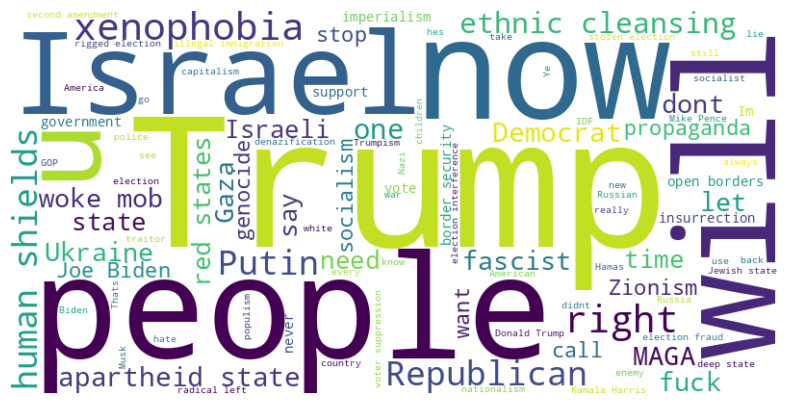

Word cloud for 'English Polarized Texts' saved to /content/drive/MyDrive/polar/wordclouds/eng_polarized_wordcloud.pdf


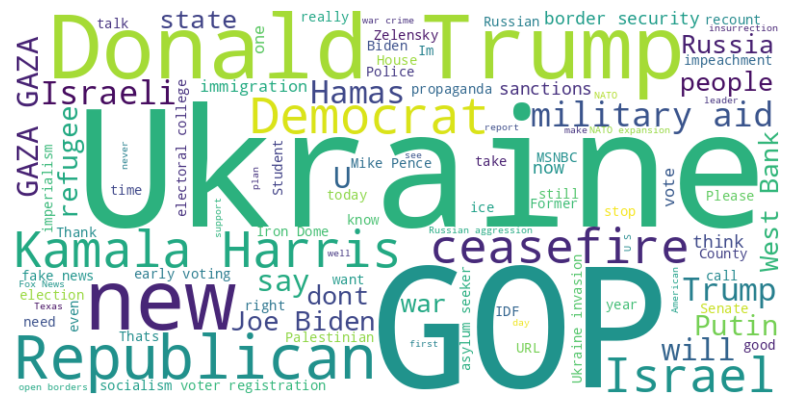

Word cloud for 'English Non-Polarized Texts' saved to /content/drive/MyDrive/polar/wordclouds/eng_non_polarized_wordcloud.pdf
Generated word clouds for English polarized and non-polarized texts.


In [ ]:
# English Polarized Word Cloud
eng_polarized_text = eng_train[eng_train['polarization'] == 1]['text']
generate_wordcloud_and_save_pdf(
    eng_polarized_text,
    os.path.join("/content/drive/MyDrive/polar/wordclouds",
                 'eng_polarized_wordcloud.pdf'),
    'English Polarized Texts'
)

# English Non-Polarized Word Cloud
eng_non_polarized_text = eng_train[eng_train['polarization'] == 0]['text']
generate_wordcloud_and_save_pdf(
    eng_non_polarized_text,
    os.path.join("/content/drive/MyDrive/polar/wordclouds",
                 'eng_non_polarized_wordcloud.pdf'),
    'English Non-Polarized Texts'
)

print("Generated word clouds for English polarized and non-polarized texts.")

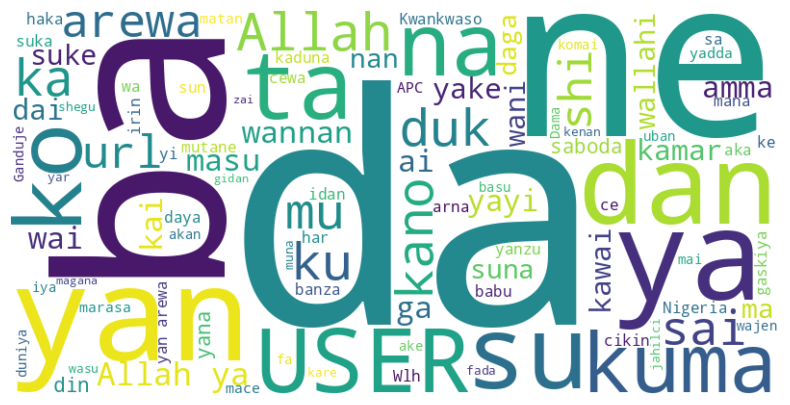

Word cloud for 'Hausa Polarized Texts' saved to /content/drive/MyDrive/polar/wordclouds/hau_polarized_wordcloud.pdf


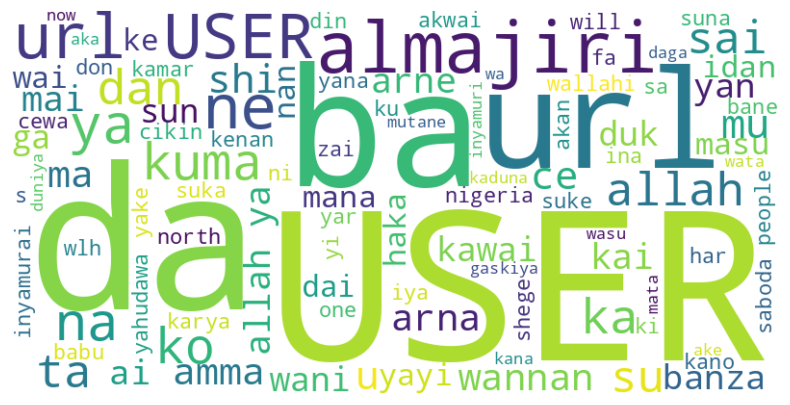

Word cloud for 'Hausa Non-Polarized Texts' saved to /content/drive/MyDrive/polar/wordclouds/hau_non_polarized_wordcloud.pdf
Generated word clouds for Hausa polarized and non-polarized texts.


In [ ]:
# Hausa Polarized Word Cloud
hau_polarized_text = hau_train[hau_train['polarization'] == 1]['text']
generate_wordcloud_and_save_pdf(
    hau_polarized_text,
    os.path.join("/content/drive/MyDrive/polar/wordclouds",
                 'hau_polarized_wordcloud.pdf'),
    'Hausa Polarized Texts'
)

# Hausa Non-Polarized Word Cloud
hau_non_polarized_text = hau_train[hau_train['polarization'] == 0]['text']
generate_wordcloud_and_save_pdf(
    hau_non_polarized_text,
    os.path.join("/content/drive/MyDrive/polar/wordclouds",
                 'hau_non_polarized_wordcloud.pdf'),
    'Hausa Non-Polarized Texts'
)

print("Generated word clouds for Hausa polarized and non-polarized texts.")

## Preprocessing

In [ ]:
# Apply preprocessing to all datasets
eng_train['text'] = eng_train['text'].apply(preprocess)
eng_dev['text'] = eng_dev['text'].apply(preprocess)

hau_train['text'] = hau_train['text'].apply(preprocess)
hau_dev['text'] = hau_dev['text'].apply(preprocess)

## Dataset Class

Creating a PyTorch dataset class

In [ ]:
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False,
                                  max_length=self.max_length,
                                  return_tensors='pt')

        # Remove .squeeze() to ensure consistent tensor shapes for DataCollatorWithPadding
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # item = {key: val for key, val in encoding.items()}

        # Handle NaN labels gracefully for prediction sets (dev set)
        if not (isinstance(label, (int, float)) and math.isnan(label)):
            item['labels'] = torch.tensor(int(label), dtype=torch.long)
        return item

## Model Setup

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=2
                                                           )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/916M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at castorini/afriteva_base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### LoRA configuration

In [ ]:
lora_config = LoraConfig(
    r=8,  # LoRA attention dimension
    lora_alpha=16,  # Alpha parameter for LoRA scaling
    target_modules=["q", "v"], # Modules to apply LoRA to
    lora_dropout=0.1,
    bias="none",  # Bias type for LoRA layers
    task_type="SEQ_CLS"  # Task type
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

## Training Setup

Preparing the data for training with both English and Hausa combined.

In [ ]:
# Combine English and Hausa training data
combined_train = pd.concat([eng_train, hau_train], ignore_index=True)
combined_dev = pd.concat([eng_dev, hau_dev], ignore_index=True)

print(f"Combined training samples: {len(combined_train)}")
print(f"Combined dev samples: {len(combined_dev)}")

Combined training samples: 13090
Combined dev samples: 342


In [ ]:
# Split combined training data for validation
train_data, val_data = train_test_split(
    combined_train,
    test_size=0.2,
    stratify=combined_train['polarization'],
    random_state=42
)

# Create datasets
train_dataset = PolarizationDataset(
    train_data['text'].tolist(),
    train_data['polarization'].tolist(),
    tokenizer
)

val_dataset = PolarizationDataset(
    val_data['text'].tolist(),
    val_data['polarization'].tolist(),
    tokenizer
)

dev_dataset = PolarizationDataset(
    combined_dev['text'].tolist(),
    combined_dev['polarization'].tolist(),
    tokenizer
)

print("Datasets created successfully!")

Datasets created successfully!


In [ ]:
# Define metrics function
def compute_metrics(p):
    # Ensure p.predictions is the actual logits tensor/array
    if isinstance(p.predictions, tuple):
        logits = p.predictions[0]
    else:
        logits = p.predictions

    preds = np.argmax(logits, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1
)

## Training

Initialize the trainer and start training.

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

model.safetensors:   0%|          | 0.00/916M [00:00<?, ?B/s]

In [ ]:
# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.484700,0.487270,0.807980


In [ ]:
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions[0], axis=1)
val_true_labels = val_dataset.labels

cm = confusion_matrix(val_true_labels, val_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Polarized', 'Polarized'],
            yticklabels=['Non-Polarized', 'Polarized'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/polar/confusion_matrix_task_1',
            format='pdf', bbox_inches='tight')
plt.show()

## Generate Predictions

Generate predictions for submission.

In [ ]:
eng_dev_dataset = PolarizationDataset(
    eng_dev['text'].tolist(),
    eng_dev['polarization'].tolist(),
    tokenizer
)

hau_dev_dataset = PolarizationDataset(
    hau_dev['text'].tolist(),
    hau_dev['polarization'].tolist(),
    tokenizer
)

In [ ]:
output_dir_lang = 'subtask_1'
os.makedirs(output_dir_lang, exist_ok=True)

# --- Generate predictions for English ---
print("Generating predictions for English...")
predictions_eng = trainer.predict(eng_dev_dataset)
predicted_labels_eng = np.argmax(predictions_eng.predictions[0], axis=1)
ids_eng = eng_dev['id'].tolist()

submission_df_eng = pd.DataFrame({
    'id': ids_eng,
    'polarization': predicted_labels_eng
})

output_filename_eng = os.path.join(output_dir_lang, 'pred_eng.csv')
submission_df_eng.to_csv(output_filename_eng, index=False)

print(f"English predictions saved to {output_filename_eng}")
print(submission_df_eng.head())

# --- Generate predictions for Hausa ---
print("Generating predictions for Hausa...")
predictions_hau = trainer.predict(hau_dev_dataset)
predicted_labels_hau = np.argmax(predictions_hau.predictions[0], axis=1)
ids_hau = hau_dev['id'].tolist()

submission_df_hau = pd.DataFrame({
    'id': ids_hau,
    'polarization': predicted_labels_hau
})

output_filename_hau = os.path.join(output_dir_lang, 'pred_hau.csv')
submission_df_hau.to_csv(output_filename_hau, index=False)

print(f"Hausa predictions saved to {output_filename_hau}")
print(submission_df_hau.head())

Generating predictions for English...


English predictions saved to subtask_1/pred_eng.csv
                                     id  polarization
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0
2  eng_95770ff547ea5e48b0be00f385986483             0
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             0
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0
Generating predictions for Hausa...


Hausa predictions saved to subtask_1/pred_hau.csv
                                     id  polarization
0  hau_7bafacd606d9dee74e7cee95f8277d4e             0
1  hau_cbf1bdd94361d60e55c6774b2a69198a             0
2  hau_8e2286abdaa2b53c5a43e2a13e11cddd             0
3  hau_1fcff27ecdc63dca7852720481daf56d             1
4  hau_fbfe2c9ca8b5bb50f1fd4cd295c95a15             0


In [ ]:
zip_filename = 'subtask_1.zip'

# Create a temporary nested structure
temp_parent = '/content/temp_parent'
target_dir = os.path.join(temp_parent, 'subtask_1', 'subtask_1')
os.makedirs(target_dir, exist_ok=True)

# Copy all CSV files into the nested directory
for file in os.listdir(output_dir_lang):
    if file.endswith('.csv'):
        shutil.copy2(
            os.path.join(output_dir_lang, file),
            os.path.join(target_dir, file)
        )

# Zip the parent directory (which contains subtask_1/subtask_1/)
shutil.make_archive('subtask_1', 'zip', temp_parent)

# Clean up
shutil.rmtree(temp_parent)

print(f'Archive created: {zip_filename}')
files.download(zip_filename)

Archive created: subtask_1.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Next Steps

1. Back-translation augmentation for Hausa data
2. LLM paraphrasing
3. EDA augmentation
4. Hausa → English translation with silver labels
5. Contextual word masking

## Data Augmentation

In [ ]:
!pip install transformers[sentencepiece] accelerate
!pip install nlpaug

In [ ]:
import nlpaug.augmenter.word as naw
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
import random
import nltk
from sentence_transformers import SentenceTransformer, util
import torch
import random
import pandas as pd
from typing import List
from tqdm.auto import tqdm

In [ ]:
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')

## Back-translation Augmentation for Hausa Texts

we'll implement back-translation using the facebook/nllb-200-3.3B-distilled model.


In [ ]:
# Set up NLLB model for translation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print("Loading NLLB translation models...")

try:
    translator_eng = pipeline(
        "translation",
        model="facebook/nllb-200-distilled-1.3B",
        src_lang="hau_Latn",
        tgt_lang="eng_Latn",
        device=device,
        dtype=dtype,
        batch_size=16
    )

    translator_back = pipeline(
        "translation",
        model="facebook/nllb-200-distilled-1.3B",
        src_lang="eng_Latn",
        tgt_lang="hau_Latn",
        device=device,
        dtype=dtype,
        batch_size=16
    )

    print("Translation models loaded successfully!")
except Exception as e:
    print(f"Error loading translation models: {e}")
    translator_eng = None
    translator_back = None

In [ ]:
def backtranslate_hausa(text, similarity_threshold=0.75):
    """
    Perform back-translation augmentation for Hausa text.

    Args:
        text (str): Original Hausa text
        similarity_threshold (float): Minimum similarity to accept augmented text

    Returns:
        str: Back-translated text if acceptable, else original text
    """
    if translator_eng is None or translator_back is None:
        return text

    try:
        # Translate Hausa to English
        eng_translation = translator_eng(text, max_length=400)[0]['translation_text']

        # Translate back to Hausa
        back_translation = translator_back(eng_translation, max_length=400)[0]['translation_text']

        # For now, we'll use a basic string similarity check
        if len(text) > 0 and len(back_translation) > 0:
            # If the back-translated text is too different, reject it
            # This is a simplified check - in practice use instructor-xl
            if abs(len(back_translation) - len(text)) / len(text) < 0.5:
                return back_translation
            else:
                return text
        else:
            return text

    except Exception as e:
        print(f"Back-translation failed for text: {text[:50]}... Error: {e}")
        return text



In [ ]:
def augment_polarized_hausa(data, num_augmentations=3):
    """
    Augment polarized Hausa examples using batched back-translation.
    Significantly faster than row-by-row processing.
    """
    # 1. Filter for polarized Hausa examples
    polarized_hausa = data[(data['polarization'] == 1) & (data['language'] == 'hau')].copy()

    if len(polarized_hausa) == 0:
        return pd.DataFrame()

    print(f"Found {len(polarized_hausa)} polarized Hausa examples for augmentation.")

    # Extract lists for batch processing
    original_texts = polarized_hausa['text'].tolist()
    original_ids = polarized_hausa['id'].tolist()

    augmented_ids = []
    augmented_texts = []
    augmented_labels = []
    augmented_languages = []

    # 2. Perform augmentation loops
    # We loop 'num_augmentations' times, processing the whole dataset in batches each time
    for i in range(num_augmentations):
        print(f"Processing augmentation round {i+1}/{num_augmentations}...")

        # --- Step A: Batch Translate Hausa -> English ---
        # We use standard generation (deterministic) for the forward pass
        # The pipeline handles the batching internally via the batch_size param set earlier
        print("  Translating Hausa -> English...")
        eng_results = translator_eng(original_texts, max_length=400)
        eng_texts = [res['translation_text'] for res in eng_results]

        # --- Step B: Batch Translate English -> Hausa ---
        # We enable sampling (do_sample=True) here to introduce variety in the back-translation
        # temperature controls creativity (0.7 is usually a good balance)
        print("  Translating English -> Hausa...")
        hau_results = translator_back(
            eng_texts,
            max_length=400,
            do_sample=True,
            temperature=0.8,
            top_k=50
        )
        back_translated_texts = [res['translation_text'] for res in hau_results]

        # --- Step C: Validation and Collection ---
        print("  Validating and collecting results...")
        for orig_text, new_text, orig_id in zip(original_texts, back_translated_texts, original_ids):

            # Simple validation: Text shouldn't be identical, and length shouldn't be drastically different
            if orig_text != new_text:
                len_ratio = len(new_text) / len(orig_text) if len(orig_text) > 0 else 0

                # Keep if length is within 50% - 150% of original
                if 0.5 < len_ratio < 1.5:
                    augmented_ids.append(f"{orig_id}_aug_bt_{i}")
                    augmented_texts.append(new_text)
                    augmented_labels.append(1) # Label is preserved
                    augmented_languages.append('hau')

    # Create DataFrame
    augmented_df = pd.DataFrame({
        'id': augmented_ids,
        'text': augmented_texts,
        'polarization': augmented_labels,
        'language': augmented_languages
    })

    print(f"Batch processing complete. Generated {len(augmented_df)} augmented examples.")
    return augmented_df

### Testing Back-translation

In [ ]:
# Test back-translation on sample texts
sample_texts = [
    "Ƙungiyar tarayya ce ta zamana kansa a Nigeria.",
    "Ana bukatar gwamnati don taimaka mutane.",
    "Ƙungiyoyin da suka faru a shekarun 2000.",
    "Ƙasar Nigeria tana da al'umma mai yawa."
]

print("Testing back-translation function:")
print("=" * 50)

for i, text in enumerate(sample_texts):
    print(f"\nSample {i+1}:")
    print(f"Original:    {text}")

    # Apply back-translation
    augmented = backtranslate_hausa(text)
    print(f"Augmented:   {augmented}")

    # Show if it changed
    if text != augmented:
        print("Status:      AUGMENTED")
    else:
        print("Status:      UNCHANGED")

# Test on actual Hausa data
print("\n" + "=" * 50)
print("Testing on actual Hausa training data:")

# Get a few polarized Hausa examples from our training data
if 'hau_train' in locals():
    polarized_hau_samples = hau_train[hau_train['polarization'] == 1].head(3)
    print(f"Found {len(polarized_hau_samples)} polarized Hausa samples")

    for idx, row in polarized_hau_samples.iterrows():
        print(f"\nOriginal ID: {row['id']}")
        print(f"Original:    {row['text']}")

        # Apply back-translation
        augmented = backtranslate_hausa(row['text'])
        print(f"Augmented:   {augmented}")

        # Show if it changed
        if row['text'] != augmented:
            print("Status:      AUGMENTED")
        else:
            print("Status:      UNCHANGED")
else:
    print("Hausa training data not available for testing")


### Applying Augmentation to Training Data

In [ ]:
# Prepare combined training data
eng_train['language'] = 'eng'
hau_train['language'] = 'hau'
combined_train = pd.concat([eng_train, hau_train], ignore_index=True)

# Apply BATCH augmentation
print("\nApplying batched back-translation augmentation...")
augmented_data = augment_polarized_hausa(combined_train, num_augmentations=3)

# Combine and Save
augmented_train = pd.concat([combined_train, augmented_data], ignore_index=True)

print(f"\nFinal training data shape: {augmented_train.shape}")
print(augmented_train['polarization'].value_counts().sort_index())

# Save checkpoints
augmented_train.to_csv("/content/drive/MyDrive/polar/back_translate_dataset_checkpoint.csv", index=False)
augmented_data.to_csv("/content/drive/MyDrive/polar/augmented_data.csv", index=False)

In [ ]:
# --- Code to load the checkpoint back ---

try:
    augmented_train = pd.read_csv("/content/drive/MyDrive/polar/back_translate_dataset_checkpoint.csv")
    augmented_data = pd.read_csv("/content/drive/MyDrive/polar/augmented_data.csv")
    print(f"\nSuccessfully loaded data from checkpoint")
    print(f"Loaded dataset shape: {augmented_train.shape}")
    print("Loaded dataset head:\n", augmented_train.head())
except FileNotFoundError:
    print(f"\nError: Checkpoint file not found. Please ensure it exists.")
except Exception as e:
    print(f"\nAn error occurred while loading the checkpoint: {e}")

## LLM Paraphrasing Augmentation

In [ ]:
llm_paraphrase_pipeline = None

print("Initializing multilingual LLM for paraphrasing...")
try:
    llm_paraphrase_pipeline = pipeline(
        "text2text-generation",
        model="google/mt5-large",
        device=0 if torch.cuda.is_available() else -1,
        batch_size=8
    )
    print("LLM paraphrasing pipeline initialized successfully!")
except Exception as e:
    print(f"Error initializing LLM paraphrasing pipeline: {e}")

In [ ]:
def llm_paraphrase_via_infilling(text: str, language: str = 'eng') -> str:
    """
    Paraphrases text by heavily masking it (35%) and letting mT5 regenerate the gaps.
    """
    # 1. Mask a significant portion of the text (35%) to force rewriting
    masked_version = mask_words_contextual(text, mask_ratio=0.35)

    # 2. If masking failed (text too short), return original
    if "<extra_id_" not in masked_version:
        return text

    # 3. Infill using the CORRECTED logic (with stitching)
    try:
        paraphrased = infill_masked_text(masked_version)
        return paraphrased
    except Exception as e:
        return text

In [ ]:
# def llm_paraphrase(text, language='english'):
#     """
#     Paraphrase text using an LLM while preserving meaning and tone.

#     Args:
#         text (str): Original text to paraphrase
#         language (str): Language of the text ('english' or 'hausa')

#     Returns:
#         str: Paraphrased text
#     """
#     global llm_paraphrase_pipeline

#     if llm_paraphrase_pipeline is None:
#         print("LLM paraphrasing pipeline not available. Returning original text.")
#         return text

#     try:
#         input_text = f"paraphrase: {text}"

#         paraphrased_output = llm_paraphrase_pipeline(input_text, max_new_tokens=128,
#                                                      min_new_tokens=10, num_beams=4,
#                                                      early_stopping=True,
#                                                      no_repeat_ngram_size=2,
#                                                      do_sample=True,
#                                                      temperature=0.7, top_k=50,
#                                                      top_p=0.95)
#         paraphrased_text = paraphrased_output[0]['generated_text']

#         # Ensure the paraphrased text is not identical to the original
#         if paraphrased_text.strip() == text.strip():
#             return text # Return original if no change

#         return paraphrased_text

#     except Exception as e:
#         print(f"Error during LLM paraphrasing for text: '{text[:50]}...'. Error: {e}")
#         return text

In [ ]:
# def augment_with_llm_paraphrasing(data, num_paraphrases=2):
#     """
#     Augment polarized examples using LLM paraphrasing.

#     Args:
#         data (pd.DataFrame): DataFrame containing texts with polarization labels
#         num_paraphrases (int): Number of paraphrases per example

#     Returns:
#         pd.DataFrame: Augmented dataset
#     """
#     # Filter for polarized examples (label = 1)
#     polarized_data = data[data['polarization'] == 1].copy()

#     print(f"Found {len(polarized_data)} polarized examples for LLM paraphrasing")

#     augmented_texts = []
#     augmented_ids = []
#     augmented_labels = []
#     augmented_languages = []

#     # Perform paraphrasing for each polarized example
#     for idx, row in polarized_data.iterrows():
#         original_text = row['text']
#         language = 'hausa' if row['language'] == 'hau' else 'english'

#         # Generate multiple paraphrases
#         for i in range(num_paraphrases):
#             paraphrased_text = llm_paraphrase(original_text, language)

#             # Only add if it's different from original
#             if paraphrased_text != original_text:
#                 augmented_texts.append(paraphrased_text)
#                 augmented_ids.append(f"{row['id']}_aug_llm_{i}")
#                 augmented_labels.append(row['polarization'])  # Keep same label
#                 augmented_languages.append(row['language'])

#     # Create DataFrame with augmented data
#     augmented_df = pd.DataFrame({
#         'id': augmented_ids,
#         'text': augmented_texts,
#         'polarization': augmented_labels,
#         'language': augmented_languages
#     })

#     print(f"Generated {len(augmented_df)} LLM paraphrased examples")
#     return augmented_df


In [ ]:
def mask_words_contextual(text: str, mask_ratio: float = 0.35) -> str:
    """
    Randomly masks spans of text with <extra_id_X> tokens.
    """
    words = text.split()
    if len(words) < 5:
        return text

    n_words = len(words)
    n_to_mask = max(1, int(n_words * mask_ratio))
    indices = sorted(random.sample(range(n_words), n_to_mask))

    spans = []
    i = 0
    while i < len(indices):
        start = indices[i]
        end = start
        while (i + 1 < len(indices) and indices[i + 1] == indices[i] + 1 and end - start < 10):
            i += 1
            end = indices[i]
        spans.append((start, end + 1))
        i += 1

    result = []
    prev_end = 0
    for idx, (start, end) in enumerate(spans):
        result.extend(words[prev_end:start])
        result.append(f"<extra_id_{idx}>")
        prev_end = end
    result.extend(words[prev_end:])

    return " ".join(result)

def stitch_t5_spans(masked_text, generated_text):
    """
    Reconstructs the full text by combining the masked input
    and the model's span outputs.
    """
    try:
        # Split input by <extra_id_X>
        input_parts = re.split(r'<extra_id_\d+>', masked_text)

        # Split output by <extra_id_X> (and remove empty strings)
        # T5 output usually starts with <extra_id_0> content <extra_id_1>...
        gen_parts = re.split(r'<extra_id_\d+>', generated_text)
        gen_parts = [g.strip() for g in gen_parts if g.strip()]

        result = ""
        # Interleave parts
        for i in range(len(input_parts)):
            result += input_parts[i].strip() + " "
            if i < len(gen_parts):
                result += gen_parts[i].strip() + " "

        return result.strip()
    except Exception:
        return masked_text # Fallback to original if stitching fails

In [ ]:
def augment_with_llm_paraphrasing_batch(data: pd.DataFrame, num_paraphrases: int = 2) -> pd.DataFrame:
    """
    Augment polarized examples using mT5 Infilling Paraphrasing in BATCHES.
    """
    if llm_paraphrase_pipeline is None:
        return pd.DataFrame()

    # Filter for polarized examples
    polarized_data = data[data['polarization'] == 1].copy()
    print(f"Preparing paraphrases for {len(polarized_data)} examples...")

    # Lists to hold batch data
    batch_inputs = []
    metadata = [] # Stores (original_id, original_text, language, iteration_index)

    # 1. Pre-generate all masked inputs
    for idx, row in polarized_data.iterrows():
        text = row['text'].strip()

        for i in range(num_paraphrases):
            # Create masked version
            masked_text = mask_words_contextual(text, mask_ratio=0.35)

            # Only add if masking actually happened
            if "<extra_id_" in masked_text:
                batch_inputs.append(masked_text)
                metadata.append({
                    'orig_id': row['id'],
                    'orig_text': text,
                    'language': row.get('language', 'eng'),
                    'iter': i,
                    'masked_input': masked_text
                })

    print(f"Running batch inference on {len(batch_inputs)} items...")

    # 2. Run Batch Inference
    # We use num_beams=5 to get high quality generation for the gaps
    outputs = llm_paraphrase_pipeline(
        batch_inputs,
        max_new_tokens=128,
        num_beams=5
    )

    # 3. Process Results
    new_rows = []

    print("Stitching and validating results...")
    for meta, output in zip(metadata, outputs):
        generated_spans = output['generated_text']

        # Stitch back together
        final_text = stitch_t5_spans(meta['masked_input'], generated_spans)

        # Quality Checks
        orig_text = meta['orig_text']

        if (final_text != orig_text and                 # Must be different
            len(final_text.split()) > 3 and             # Not too short
            len(final_text) < len(orig_text) * 2 and    # Not hallucinating too much length
            final_text.lower() not in orig_text.lower()): # Not just a substring

            new_rows.append({
                'id': f"{meta['orig_id']}_para_{meta['iter']}_{random.randint(100,999)}",
                'text': final_text,
                'polarization': 1,
                'language': meta['language']
            })

    result_df = pd.DataFrame(new_rows)
    print(f"Generated {len(result_df)} valid paraphrases.")
    return result_df

### Testing LLM Paraphrasing

In [ ]:
# ------------------- TEST THE FIX -------------------
sample_texts = [
    ("This is a polarized English statement.", "english"),
    ("Ƙungiyar tarayya ce ta zamana kansa.", "hausa"),
    ("We must stand together against injustice.", "english"),
    ("Ana bukatar gwamnati don taimaka mutane.", "hausa")
]

print("Testing mT5 Infilling Paraphraser:")
print("=" * 50)

for i, (text, lang) in enumerate(sample_texts):
    print(f"\nSample {i+1} ({lang}):")
    print(f"Original:    {text}")

    # Apply Paraphrasing
    paraphrased = llm_paraphrase_via_infilling(text, lang)
    print(f"Paraphrased: {paraphrased}")

    if text != paraphrased:
        print("Status:      SUCCESS")
    else:
        print("Status:      UNCHANGED (Text might be too short)")

In [ ]:
# Apply LLM paraphrasing to our previously augmented training data
print("\n" + "=" * 50)
print("Applying Batch LLM paraphrasing...")

llm_augmented_data = augment_with_llm_paraphrasing_batch(augmented_train, num_paraphrases=2)

print(f"LLM paraphrased data shape: {llm_augmented_data.shape}")

# Combine with existing augmented data
fully_augmented_train = pd.concat([augmented_train, llm_augmented_data], ignore_index=True)
print(f"Fully augmented training data shape: {fully_augmented_train.shape}")

# Show final statistics
print("\nFinal Data Statistics:")
print(f"Total samples: {len(fully_augmented_train)}")
print("\nFinal Polarization Distribution:")
print(fully_augmented_train['polarization'].value_counts().sort_index())

# --- Save the complete augmented dataset ---
checkpoint_filename = "/content/drive/MyDrive/polar/paraphrase_dataset_checkpoint.csv"
fully_augmented_train.to_csv(checkpoint_filename, index=False)
llm_augmented_data.to_csv("/content/drive/MyDrive/polar/llm_augmented_data.csv", index=False)
print(f"Data checkpoint saved to: {checkpoint_filename}")

In [ ]:
# --- Code to load the checkpoint back (for later use or if notebook restarts) ---

try:
    fully_augmented_train = pd.read_csv("/content/drive/MyDrive/polar/paraphrase_dataset_checkpoint.csv")
    llm_augmented_data = pd.read_csv("/content/drive/MyDrive/polar/llm_augmented_data.csv")
    print(f"\nSuccessfully loaded data from checkpoint")
    print(f"Loaded dataset shape: {fully_augmented_train.shape}")
    print("Loaded dataset head:\n", fully_augmented_train.head())
except FileNotFoundError:
    print(f"\nError: Checkpoint file not found. Please ensure it exists.")
except Exception as e:
    print(f"\nAn error occurred while loading the checkpoint: {e}")

## EDA (Easy Data Augmentation) Implementation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Initializing EDA models...")

# Multilingual contextual
contextual_aug = naw.ContextualWordEmbsAug(
    model_path="FacebookAI/xlm-roberta-large",
    action="substitute",
    aug_p=0.3,
    top_k=10,
    device=device,
    batch_size=32
)

insert_aug = naw.ContextualWordEmbsAug(
    model_path="FacebookAI/xlm-roberta-large",
    action="insert",
    aug_p=0.25,
    device=device,
    batch_size=32
)

delete_aug = naw.RandomWordAug(action="delete", aug_p=0.2)
swap_aug   = naw.RandomWordAug(action="swap", aug_max=4)
english_syn_aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

print("EDA models initialized.")

In [ ]:
# ====================== INDIVIDUAL EDA FUNCTIONS ======================
def eda_synonym_replacement(text: str, language: str = 'english'):
    if language == 'english':
        return english_syn_aug.augment(text)[0] if text.strip() else text
    else:
        return contextual_aug.augment(text)[0] if text.strip() else text

def eda_random_insertion(text: str, language: str = 'english'):
    return insert_aug.augment(text)[0] if text.strip() else text

def eda_random_deletion(text: str, language: str = 'english'):
    return delete_aug.augment(text)[0] if text.strip() else text

def eda_random_swap(text: str, language: str = 'english'):
    return swap_aug.augment(text)[0] if text.strip() else text

def apply_eda_augmentation(text: str, language: str = 'english', num_aug: int = 4):
    """
    Generate `num_aug` different augmented versions
    """
    augs = [delete_aug, swap_aug, insert_aug]
    if language == 'english':
        augs.append(english_syn_aug)
    augs.append(contextual_aug)

    results = []
    seen = {text}

    for _ in range(num_aug * 2):  # Oversample a bit to guarantee diversity
        aug = random.choice(augs)
        try:
            new_text = aug.augment(text)
            if isinstance(new_text, list):
                new_text = new_text[0]
            if new_text not in seen and len(new_text.split()) > 5:
                seen.add(new_text)
                results.append(new_text)
                if len(results) >= num_aug:
                    break
        except:
            continue
    return results if results else [text]

In [ ]:
# ====================== FULL AUGMENT FUNCTION (multiplier) ======================
def augment_with_eda(data: pd.DataFrame, multiplier: int = 4):
    """
    Augment ONLY polarized examples with `multiplier` new samples each.
    """
    polarized_data = data[data['polarization'] == 1].copy()
    print(f"Found {len(polarized_data)} polarized examples → generating {multiplier}x each")

    aug_rows = []
    for _, row in polarized_data.iterrows():
        lang = 'hausa' if row.get('language', '').startswith('hau') else 'english'
        aug_texts = apply_eda_augmentation(row['text'], language=lang, num_aug=multiplier)

        for aug_text in aug_texts:
            aug_rows.append({
                'id': f"{row['id']}_eda_{random.randint(1000,9999)}",
                'text': aug_text,
                'polarization': 1,
                'language': row.get('language', lang)
            })

    aug_df = pd.DataFrame(aug_rows)
    print(f"Generated {len(aug_df)} high-quality EDA samples")
    return aug_df

def augment_with_eda_batch(data: pd.DataFrame, multiplier: int = 4):
    """
    Augment polarized examples using Batched EDA.
    Separates English and Hausa to apply appropriate augmenters efficiently.
    """
    # 1. Split Data by Language
    eng_data = data[(data['polarization'] == 1) & (data['language'] == 'eng')].copy()
    hau_data = data[(data['polarization'] == 1) & (data['language'] == 'hau')].copy()

    print(f"Found {len(eng_data)} English and {len(hau_data)} Hausa polarized examples.")

    new_rows = []

    # --- Define Available Augmenters ---
    # Hausa: XLM-R (Sub/Ins), Random (Swap/Del)
    hau_augmenters = [contextual_aug, insert_aug, swap_aug, delete_aug]

    # English: XLM-R (Sub/Ins), Random (Swap/Del), WordNet
    eng_augmenters = [contextual_aug, insert_aug, swap_aug, delete_aug, english_syn_aug]

    # --- Helper to process a batch ---
    def process_batch(df, augmenters_list, prefix):
        if df.empty: return

        # Extract lists once
        texts = df['text'].tolist()
        ids = df['id'].tolist()
        langs = df['language'].tolist()

        # Loop for the number of requested augmentations (multiplier)
        for i in range(multiplier):
            # Pick an augmenter for this round
            aug_engine = augmenters_list[i % len(augmenters_list)]

            print(f"  [{prefix}] Round {i+1}/{multiplier}: Applying {type(aug_engine).__name__}...")

            # BATCH INFERENCE
            try:
                augmented_texts = aug_engine.augment(texts)
            except Exception as e:
                print(f"    Error in batch augmentation: {e}")
                continue

            # Collect results
            # FIX: We now zip 'texts' as well so we have the original text for comparison
            for original_id, aug_text, lang, original_txt in zip(ids, augmented_texts, langs, texts):

                # Handle case where nlpaug returns a list inside a list
                if isinstance(aug_text, list):
                    aug_text = aug_text[0]

                # Basic validation
                # Check if text changed AND is not too short
                if aug_text != original_txt and len(aug_text.strip()) > 5:
                     new_rows.append({
                        'id': f"{original_id}_eda_{i}_{random.randint(100,999)}",
                        'text': aug_text,
                        'polarization': 1,
                        'language': lang
                    })

    # 2. Process Batches
    if not eng_data.empty:
        process_batch(eng_data, eng_augmenters, "ENG")

    if not hau_data.empty:
        process_batch(hau_data, hau_augmenters, "HAU")

    result_df = pd.DataFrame(new_rows)
    print(f"Batch EDA complete. Generated {len(result_df)} samples.")
    return result_df

### Testing EDA Augmentation

In [ ]:
# ====================== TESTING ON SAMPLE TEXTS ======================
sample_texts = [
    ("This is a polarized English statement with multiple words.", "english"),
    ("Ƙungiyar tarayya ce ta zamana kansa a Nigeria.", "hausa"),
    ("We must stand together against injustice and oppression.", "english"),
    ("Ana bukatar gwamnati don taimaka mutane masu dauki abubuwa.", "hausa")
]

print("Testing EDA augmentation functions:")
print("=" * 60)

for i, (text, lang) in enumerate(sample_texts):
    print(f"\nSample {i+1} ({lang}):\nOriginal:  {text}\n")

    print(f"Synonym:   {eda_synonym_replacement(text, lang)}")
    print(f"Insertion: {eda_random_insertion(text, lang)}")
    print(f"Deletion:  {eda_random_deletion(text, lang)}")
    print(f"Swap:      {eda_random_swap(text, lang)}")

    mixed = apply_eda_augmentation(text, lang, num_aug=3)
    print(f"Mixed EDA (3x):")
    for j, t in enumerate(mixed, 1):
        print(f"  {j}. {t}")
    print("-" * 60)

In [ ]:
# ====================== APPLY TO YOUR FULL DATA ======================
print("\n" + "=" * 60)
print("Applying Batched EDA augmentation...")

# Note: We use fully_augmented_train (Original + BackTrans + Paraphrase)
# This creates variations of variations, which is very powerful for small datasets.
eda_augmented_data = augment_with_eda_batch(fully_augmented_train, multiplier=4)

complete_augmented_train = pd.concat([fully_augmented_train, eda_augmented_data], ignore_index=True)
print(f"Complete augmented training data shape: {complete_augmented_train.shape}")

# Final statistics
print("\nComplete Data Statistics:")
print(f"Total final samples: {len(complete_augmented_train)}")
print("\nFinal Polarization Distribution:")
print(complete_augmented_train['polarization'].value_counts().sort_index())

# --- Save the complete augmented dataset ---
checkpoint_filename = "/content/drive/MyDrive/polar/eda_dataset_checkpoint.csv"
complete_augmented_train.to_csv(checkpoint_filename, index=False)
eda_augmented_data.to_csv("/content/drive/MyDrive/polar/eda_augmented_data.csv", index=False)
print(f"Data checkpoint saved to: {checkpoint_filename}")

In [ ]:
# --- Code to load the checkpoint back ---

try:
    complete_augmented_train = pd.read_csv("/content/drive/MyDrive/polar/eda_dataset_checkpoint.csv")
    eda_augmented_data = pd.read_csv("/content/drive/MyDrive/polar/eda_augmented_data.csv")
    print(f"\nSuccessfully loaded data from checkpoint")
    print(f"Loaded dataset shape: {complete_augmented_train.shape}")
    print("Loaded dataset head:\n", complete_augmented_train.head())
except FileNotFoundError:
    print(f"\nError: Checkpoint file not found. Please ensure it exists.")
except Exception as e:
    print(f"\nAn error occurred while loading the checkpoint: {e}")

## Hausa to English Translation with Silver Labels

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

translator_eng = pipeline(
    "translation",
    model="facebook/nllb-200-distilled-1.3B",
    src_lang="hau_Latn",
    tgt_lang="eng_Latn",
    device=device,
    dtype=dtype,
    batch_size=16
)

english_classifier = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    top_k=None,
    device=device,
    batch_size=32,
    dtype=dtype
)

In [ ]:
def augment_with_hausa_to_english_silver_labels_batch(
    hausa_data: pd.DataFrame,
    confidence_threshold: float = 0.85
) -> pd.DataFrame:
    """
    Translate Hausa → English → Predict Sentiment → Map to Polarization.
    Polarization = Negative + Positive
    Neutral = Neutral
    """
    # Create copy and handle missing language column
    df = hausa_data.copy()
    if 'language' not in df.columns:
        df['language'] = 'hau'

    hausa_subset = df[df['language'] == 'hau'].copy()

    if hausa_subset.empty:
        print("No Hausa data found.")
        return pd.DataFrame()

    print(f"Found {len(hausa_subset)} Hausa examples → translating + silver labeling...")

    # Extract texts
    hausa_texts = hausa_subset['text'].tolist()

    # --- Step 1: Batch Translation ---
    print("  Batch translating Hausa -> English...")
    try:
        # Added truncation=True to fix the length warnings
        translated_results = translator_eng(hausa_texts, max_length=512, truncation=True)
        translated_texts = [res['translation_text'] for res in translated_results]
    except Exception as e:
        print(f"Translation failed: {e}")
        return pd.DataFrame()

    # --- Step 2: Batch Classification ---
    print("  Batch classifying English texts...")
    try:
        predictions = english_classifier(
            translated_texts,
            truncation=True,
            max_length=512
        )
    except Exception as e:
        print(f"Classification failed: {e}")
        return pd.DataFrame()

    # --- Step 3: Filtering & Logic Mapping ---
    silver_rows = []
    kept = 0

    for orig_row, eng_text, pred in zip(hausa_subset.itertuples(), translated_texts, predictions):
        # pred is list of dicts, e.g., [{'label': 'negative', 'score': 0.9}, ...]
        # Map labels to scores.
        # Note: Model labels are usually 'negative', 'neutral', 'positive'
        scores = {p['label']: p['score'] for p in pred}

        neg = scores.get('negative', 0.0)
        neu = scores.get('neutral', 0.0)
        pos = scores.get('positive', 0.0)

        # LOGIC: Polarization implies strong opinion (Positive OR Negative)
        polarization_score = neg + pos
        neutral_score = neu

        # Determine label
        if polarization_score > neutral_score:
            pred_label = 1
            confidence = polarization_score
        else:
            pred_label = 0
            confidence = neutral_score

        # Filter by confidence
        if confidence >= confidence_threshold:
            silver_rows.append({
                'id': f"{orig_row.id}_silver_eng",
                'text': eng_text,
                'polarization': pred_label,
                'language': 'eng',
                'source': 'hausa_silver',
                'confidence': round(confidence, 4)
            })
            kept += 1

    silver_df = pd.DataFrame(silver_rows)
    print(f"Generated {len(silver_df)} high-confidence silver English examples "
          f"({kept/len(hausa_subset)*100:.1f}% of Hausa data kept @ {confidence_threshold})")
    return silver_df

### Testing Hausa to English Translation with Silver Labels

Let's test our Hausa to English translation with silver labels function.


In [ ]:
print("Testing Hausa → English translation + silver polarization labeling:")
print("=" * 70)

sample_hausa_texts = [
    "Ƙungiyar tarayya ce ta zamana kansa a Nigeria.", # Neutral/Factual
    "Ana bukatar gwamnati don taimaka mutane.",      # Slightly Positive/Demand
    "Mu ba za mu yarda da wannan zalunci ba a ƙasar mu.", # Strong Negative (Polarized)
    "Ƙasar Nigeria tana da al'umma mai yawa da bambancin addinai." # Neutral
]

# 1. Translate
test_trans = translator_eng(sample_hausa_texts, max_length=512, truncation=True)
test_eng_texts = [t['translation_text'] for t in test_trans]

# 2. Predict
test_preds = english_classifier(test_eng_texts)

for i, (h_text, e_text, pred) in enumerate(zip(sample_hausa_texts, test_eng_texts, test_preds)):
    print(f"\nSample {i+1}:")
    print(f"Hausa:       {h_text}")
    print(f"Translated:  {e_text}")

    # Extract scores based on new model labels
    scores = {p['label']: p['score'] for p in pred}
    neg = scores.get('negative', 0.0)
    neu = scores.get('neutral', 0.0)
    pos = scores.get('positive', 0.0)

    # Calculate Polarization vs Neutrality
    polarization_score = neg + pos
    neutral_score = neu

    pred_label = 1 if polarization_score > neutral_score else 0
    confidence = max(polarization_score, neutral_score)

    print(f"Scores:      Neg={neg:.2f}, Neu={neu:.2f}, Pos={pos:.2f}")
    print(f"Prediction:  {pred_label} (confidence: {confidence:.3f})")
    print("-" * 70)

In [ ]:
# APPLY TO FULL HAUSA TRAINING DATA
print("\n" + "=" * 70)
print("Generating high-confidence silver-labeled English data from Hausa train...")

# Use the new BATCH function
silver_labeled_data = augment_with_hausa_to_english_silver_labels_batch(
    hau_train,                    # original Hausa DataFrame
    confidence_threshold=0.95     # Keeps only very clean predictions
)

print(f"Silver-labeled English data shape: {silver_labeled_data.shape}")
if len(hau_train) > 0:
    print(f"Kept {len(silver_labeled_data)/len(hau_train)*100:.1f}% of Hausa examples as high-confidence silver data")

# COMBINE WITH CURRENT BEST AUGMENTED DATA
final_augmented_train = pd.concat([complete_augmented_train, silver_labeled_data], ignore_index=True)
print(f"\nFinal augmented training data shape: {final_augmented_train.shape}")

# --- Save the complete augmented dataset as a checkpoint ---
checkpoint_filename = "/content/drive/MyDrive/polar/silver_dataset_checkpoint.csv"
final_augmented_train.to_csv(checkpoint_filename, index=False)
silver_labeled_data.to_csv("/content/drive/MyDrive/polar/silver_labeled_data.csv", index=False)
print(f"Data checkpoint saved to: {checkpoint_filename}")

In [ ]:
# FINAL STATISTICS
print("\n" + "=" * 70)
print("FINAL DATASET BREAKDOWN")
print("=" * 70)

total_original = len(eng_train) + len(hau_train)
print(f"Original total samples:           {total_original:,}")
print(f"After all augmentations:          {len(final_augmented_train):,} (+{len(final_augmented_train)/total_original:.2f}x)")

print("\nPolarization Distribution (Final):")
print(final_augmented_train['polarization'].value_counts().sort_index())

print("\nLanguage Distribution (Final):")
print(final_augmented_train['language'].value_counts().sort_index())

print("\nPolarization × Language Breakdown:")
print(final_augmented_train.groupby(['language', 'polarization']).size().unstack(fill_value=0))

# Augmentation Multiplier on Polarized Class
orig_eng_pol = len(eng_train[eng_train['polarization'] == 1])
orig_hau_pol = len(hau_train[hau_train['polarization'] == 1])

final_eng_pol = len(final_augmented_train[
    (final_augmented_train['language'] == 'eng') &
    (final_augmented_train['polarization'] == 1)
])
final_hau_pol = len(final_augmented_train[
    (final_augmented_train['language'] == 'hau') &
    (final_augmented_train['polarization'] == 1)
])

print(f"\nAugmentation Ratio on Polarized Class:")
print(f"  English: {final_eng_pol / orig_eng_pol:.2f}× (from {orig_eng_pol} → {final_eng_pol})")
print(f"  Hausa:   {final_hau_pol / orig_hau_pol:.2f}× (from {orig_hau_pol} → {final_hau_pol})")

In [ ]:
# --- Code to load the checkpoint back ---

try:
    final_augmented_train = pd.read_csv("/content/drive/MyDrive/polar/silver_dataset_checkpoint.csv")
    silver_labeled_data = pd.read_csv("/content/drive/MyDrive/polar/silver_labeled_data.csv")
    print(f"\nSuccessfully loaded data from checkpoint")
    print(f"Loaded dataset shape: {final_augmented_train.shape}")
    print("Loaded dataset head:\n", final_augmented_train.head())
except FileNotFoundError:
    print(f"\nError: Checkpoint file not found. Please ensure it exists.")
except Exception as e:
    print(f"\nAn error occurred while loading the checkpoint: {e}")

## Contextual Word Masking


In [ ]:
if 'llm_paraphrase_pipeline' in locals() and llm_paraphrase_pipeline is not None:
    print("Using existing pipeline model...")
    infiller_model = llm_paraphrase_pipeline.model
    infiller_tokenizer = llm_paraphrase_pipeline.tokenizer
else:
    print("Loading mT5 manually...")
    infiller_tokenizer = AutoTokenizer.from_pretrained("google/mt5-large")
    infiller_model = AutoModelForSeq2SeqLM.from_pretrained(
        "google/mt5-large",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    if torch.cuda.is_available():
        infiller_model = infiller_model.cuda()

In [ ]:
def infill_masked_text(masked_texts: List[str]) -> List[str]:
    # Filter out empty or unmasked texts to avoid errors and simplify processing
    valid_indices = [i for i, text in enumerate(masked_texts) if "<extra_id_" in text and text.strip()]
    if not valid_indices:
        return list(masked_texts) # Return originals if no valid masks

    texts_to_process = [masked_texts[i] for i in valid_indices]

    inputs = infiller_tokenizer(
        texts_to_process,  # Pass a list for batch tokenization
        return_tensors="pt",
        padding=True,      # Important for batching
        truncation=True,
        max_length=512
    ).to(infiller_model.device)

    with torch.no_grad():
        output_ids = infiller_model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,
            temperature=0.9,
            top_p=0.95,
            repetition_penalty=1.2
        )

    generated_spans_batch = infiller_tokenizer.batch_decode(output_ids, skip_special_tokens=False)

    final_texts = list(masked_texts) # Start with copies of original masked_texts

    for i, original_masked_text_in_batch in enumerate(texts_to_process):
        # The index in the original batch `masked_texts`
        original_idx = valid_indices[i]
        generated_span = generated_spans_batch[i]

        current_final_text = original_masked_text_in_batch
        matches = re.findall(r"<extra_id_(\d+)>(.*?)(?=<extra_id_|</s>|$)", generated_span)

        for idx_str, content in matches:
            sentinel = f"<extra_id_{idx_str}>"
            content = content.strip()
            if sentinel in current_final_text:
                current_final_text = current_final_text.replace(sentinel, content, 1)

        current_final_text = re.sub(r'\s+', ' ', current_final_text).strip()
        final_texts[original_idx] = current_final_text # Update the text at its original position

    return final_texts

In [ ]:
# --- Helper: Masking (CPU) ---
def mask_words_contextual(text: str, mask_ratio: float = 0.15) -> str:
    words = text.split()
    if len(words) < 5:
        return text

    n_words = len(words)
    n_to_mask = max(1, int(n_words * mask_ratio))
    indices = sorted(random.sample(range(n_words), n_to_mask))

    spans = []
    i = 0
    while i < len(indices):
        start = indices[i]
        end = start
        while (i + 1 < len(indices) and indices[i + 1] == indices[i] + 1 and end - start < 10):
            i += 1
            end = indices[i]
        spans.append((start, end + 1))
        i += 1

    result = []
    prev_end = 0
    for idx, (start, end) in enumerate(spans):
        result.extend(words[prev_end:start])
        result.append(f"<extra_id_{idx}>")
        prev_end = end
    result.extend(words[prev_end:])

    return " ".join(result)

# --- Helper: Batch Stitching (CPU) ---
def stitch_batch(original_masked_texts, generated_spans):
    final_texts = []
    for masked_text, gen_span in zip(original_masked_texts, generated_spans):
        current_text = masked_text
        # Extract <extra_id_X> content
        matches = re.findall(r"<extra_id_(\d+)>(.*?)(?=<extra_id_|</s>|$)", gen_span)

        for idx_str, content in matches:
            sentinel = f"<extra_id_{idx_str}>"
            if sentinel in current_text:
                current_text = current_text.replace(sentinel, content.strip(), 1)

        final_texts.append(re.sub(r'\s+', ' ', current_text).strip())
    return final_texts

In [ ]:
# ------------------- 2. Multilingual Similarity Checker -------------------
similarity_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

def compute_similarity(text1: str, text2: str, threshold: float = 0.8) -> float:
    """
    Compute cosine similarity using multilingual MPNet (filters bad infills).
    Returns score; use > threshold to accept.
    """
    if not text1.strip() or not text2.strip():
        return 0.0

    emb1 = similarity_model.encode(text1)
    emb2 = similarity_model.encode(text2)
    sim = util.cos_sim(emb1, emb2).item()
    return sim

In [ ]:
def augment_with_contextual_masking(
    data: pd.DataFrame,
    multiplier: int = 3,
    sim_threshold: float = 0.70
) -> pd.DataFrame:

    # Filter for polarized data
    polarized = data[data['polarization'] == 1].copy()
    print(f"Applying mT5 contextual masking to {len(polarized)} polarized examples (Target: {multiplier} augs per row)")

    new_rows = []

    for _, row in tqdm(polarized.iterrows(), total=len(polarized)):
        text = row['text'].strip()
        lang = row.get('language', 'eng')

        # Counter for successful augmentations for THIS row
        success_count = 0

        # Safety limit: try at most (multiplier * 3) times to find good ones
        # to prevent infinite loops on difficult sentences
        attempts = 0
        max_attempts = multiplier * 3

        while success_count < multiplier and attempts < max_attempts:
            attempts += 1

            try:
                # 1. Mask
                masked = mask_words_contextual(text)
                if "<extra_id_" not in masked:
                    continue

                # 2. Infill (using the corrected function from previous step)
                aug_text = infill_masked_text(masked)

                # 3. Validate
                # Basic length check to save time on similarity calc
                if len(aug_text.split()) < 5:
                    continue

                # Similarity check
                sim = compute_similarity(text, aug_text)

                # 4. Filter Logic
                if (sim >= sim_threshold and
                    sim != 1.0 and  # Add this condition to reject identical augmentations
                    aug_text != text and
                    # Ensure we didn't just delete words (augmentation shouldn't be a substring of original)
                    aug_text.lower() not in text.lower()):

                    new_rows.append({
                        'id': f"{row['id']}_mt5_{success_count}_{random.randint(100,999)}",
                        'text': aug_text,
                        'polarization': 1,
                        'language': lang
                    })

                    success_count += 1
            except Exception as e:
                # print(f"Error: {e}") # Uncomment for debugging
                continue

    result_df = pd.DataFrame(new_rows)
    print(f"Done! Generated {len(result_df)} high-quality mT5 augmentations.")
    return result_df

In [ ]:
def augment_with_contextual_masking_batch(
    data: pd.DataFrame,
    multiplier: int = 2,
    sim_threshold: float = 0.80,
    mask_ratio: float = 0.15,
    batch_size: int = 32,
    checkpoint_path: str = None,
    save_every_batches: int = 50
) -> pd.DataFrame:

    # 1. Filter Data
    polarized = data[data['polarization'] == 1].copy()
    print(f"Applying Batch mT5 masking to {len(polarized)} examples (Target: {multiplier}x each)")

    # 2. Pre-generate Masked Inputs
    tasks = []
    for _, row in polarized.iterrows():
        text = row['text'].strip()
        if len(text.split()) < 4: continue

        for i in range(multiplier):
            masked = mask_words_contextual(text, mask_ratio=mask_ratio)
            if "<extra_id_" in masked:
                tasks.append({
                    'orig_id': row['id'],
                    'orig_text': text,
                    'masked_text': masked,
                    'language': row.get('language', 'eng'),
                    'iter': i
                })

    print(f"Generated {len(tasks)} masked candidates. Processing in batches of {batch_size}...")

    valid_rows = []
    batch_count = 0

    # 3. Process in Batches
    for i in range(0, len(tasks), batch_size):
        batch = tasks[i : i + batch_size]
        batch_count += 1

        # Extract lists
        batch_masked = [b['masked_text'] for b in batch]
        batch_orig = [b['orig_text'] for b in batch]

        # --- A. Batch Infilling (mT5) ---
        try:
            inputs = infiller_tokenizer(
                batch_masked,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(infiller_model.device)

            with torch.no_grad():
                output_ids = infiller_model.generate(
                    **inputs,
                    max_new_tokens=128,
                    do_sample=True,
                    temperature=0.9,
                    top_p=0.95
                )

            generated_spans = infiller_tokenizer.batch_decode(output_ids, skip_special_tokens=False)
            batch_filled = stitch_batch(batch_masked, generated_spans)

        except Exception as e:
            print(f"Batch generation failed: {e}")
            continue

        # --- B. Batch Similarity ---
        try:
            orig_embs = similarity_model.encode(batch_orig, convert_to_tensor=True, show_progress_bar=False)
            aug_embs = similarity_model.encode(batch_filled, convert_to_tensor=True, show_progress_bar=False)
            sim_scores = util.pairwise_cos_sim(orig_embs, aug_embs)

        except Exception as e:
            print(f"Batch similarity failed: {e}")
            continue

        # --- C. Filter and Collect ---
        for j, task in enumerate(batch):
            aug_text = batch_filled[j]
            score = sim_scores[j].item()
            orig_text = task['orig_text']

            if (score >= sim_threshold and
                score < 0.99 and
                len(aug_text.split()) >= 4 and
                aug_text.lower() != orig_text.lower() and
                aug_text.lower() not in orig_text.lower()):

                valid_rows.append({
                    'id': f"{task['orig_id']}_mt5_{task['iter']}_{random.randint(100,999)}",
                    'text': aug_text,
                    'polarization': 1,
                    'language': task['language']
                })

        # --- D. CHECKPOINT SAVING ---
        if checkpoint_path and (batch_count % save_every_batches == 0):
            if len(valid_rows) > 0:
                temp_df = pd.DataFrame(valid_rows)
                temp_df.to_csv(checkpoint_path, index=False)
                print(f"  [Checkpoint] Saved {len(temp_df)} generated samples to {checkpoint_path}")

        # Print progress
        if (i // batch_size) % 20 == 0:
            print(f"Processed {i}/{len(tasks)} candidates... Found {len(valid_rows)} valid so far.")

    result_df = pd.DataFrame(valid_rows)

    # Final save
    if checkpoint_path and not result_df.empty:
        result_df.to_csv(checkpoint_path, index=False)
        print(f"Final checkpoint saved to {checkpoint_path}")

    print(f"Done! Generated {len(result_df)} high-quality mT5 augmentations.")
    return result_df

### Testing Contextual Word Masking

Let's test our contextual word masking augmentation functions.


In [ ]:
print("Testing contextual word masking + umT5 infilling on sample texts:")
print("=" * 80)

sample_texts = [
    "This is a polarized English statement with multiple words for testing.",
    "Ƙungiyar tarayya ce ta zamana kansa a Nigeria da alƙawarin da ke saman sa.",
    "We must stand together against injustice and oppression in our society.",
    "Ana bukatar gwamnati don taimaka mutane masu dauki abubuwa da basira."
]

for i, text in enumerate(sample_texts):
    print(f"\nSample {i+1}:")
    print(f"Original:   {text}")

    masked = mask_words_contextual(text, mask_ratio=0.15)
    print(f"Masked:     {masked}")

    infilled = infill_masked_text(masked)
    print(f"Infilled:   {infilled}")

    sim = compute_similarity(text, infilled)
    status = "ACCEPTED" if sim >= 0.8 else "REJECTED"
    print(f"Similarity: {sim:.3f} → {status}")
    print("-" * 80)

In [ ]:
# APPLY TO FULL FINAL AUGMENTED TRAINING DATA
print("\n" + "=" * 80)
print("Applying high-quality BATCHED contextual masking augmentation...")

# Define a path for the intermediate/partial results
partial_save_path = "/content/drive/MyDrive/polar/partial_contextual_aug.csv"

contextual_augmented_data = augment_with_contextual_masking_batch(
    final_augmented_train,
    mask_ratio=0.15,
    sim_threshold=0.80,
    multiplier=2,
    batch_size=32,
    checkpoint_path=partial_save_path,
    save_every_batches=50
)

print(f"Contextual masking augmented data shape: {contextual_augmented_data.shape}")

# FINAL COMBINATION
complete_augmentation_dataset = pd.concat(
    [final_augmented_train, contextual_augmented_data],
    ignore_index=True
)
print(f"\nCOMPLETE FINAL DATASET shape: {complete_augmentation_dataset.shape}")
print("\nFinal Polarization Distribution:")
print(complete_augmentation_dataset['polarization'].value_counts().sort_index())

# --- Save the complete augmented dataset as a final checkpoint ---
checkpoint_filename = "/content/drive/MyDrive/polar/mask_dataset_checkpoint.csv"
complete_augmentation_dataset.to_csv(checkpoint_filename, index=False)
contextual_augmented_data.to_csv("/content/drive/MyDrive/polar/contextual_augmented_data.csv", index=False)
print(f"Final Data checkpoint saved to: {checkpoint_filename}")

In [ ]:
# --- Code to load the checkpoint back (for later use or if notebook restarts) ---

try:
    complete_augmentation_dataset = pd.read_csv("/content/drive/MyDrive/polar/mask_dataset_checkpoint.csv")
    contextual_augmented_data = pd.read_csv("/content/drive/MyDrive/polar/contextual_augmented_data.csv")
    print(f"\nSuccessfully loaded data from checkpoint")
    print(f"Loaded dataset shape: {complete_augmentation_dataset.shape}")
    print("Loaded dataset head:\n", complete_augmentation_dataset.head())
except FileNotFoundError:
    print(f"\nError: Checkpoint file not found. Please ensure it exists.")
except Exception as e:
    print(f"\nAn error occurred while loading the checkpoint: {e}")

In [ ]:
# FINAL STATISTICS & BREAKDOWN
print("\n" + "=" * 80)
print("COMPLETE AUGMENTATION PIPELINE STATISTICS (Dec 2025 SOTA)")
print("=" * 80)

total_original = len(eng_train) + len(hau_train)
print(f"Original total samples:                     {total_original:,}")
print(f"After ALL augmentations:                    {len(complete_augmentation_dataset):,} "
      f"(+{len(complete_augmentation_dataset)/total_original:.2f}x)")

print("\nBreakdown of Augmentation Techniques:")
print(f"  • Back-translation                        → {len(augmented_data):,}")
print(f"  • LLM paraphrasing                        → {len(llm_augmented_data):,}")
print(f"  • EDA (XLM-R contextual)                  → {len(eda_augmented_data):,}")
print(f"  • Hausa→Eng silver labels (NLLB + RoBERTa)→ {len(silver_labeled_data):,}")
print(f"  • Contextual masking (mT5 + MPNet filter) → {len(contextual_augmented_data):,}")
print(f"  → TOTAL FINAL SAMPLES:                    {len(complete_augmentation_dataset):,}")

print("\nFinal Language Distribution:")
print(complete_augmentation_dataset['language'].value_counts().sort_index())

print("\nFinal Polarization Distribution:")
print(complete_augmentation_dataset['polarization'].value_counts().sort_index())

print("\nPolarization × Language Breakdown:")
print(complete_augmentation_dataset.groupby(['language', 'polarization']).size().unstack(fill_value=0))

# AUGMENTATION RATIO ON POLARIZED CLASS (THE MOST IMPORTANT METRIC)
orig_eng_pol = len(eng_train[eng_train['polarization'] == 1])
orig_hau_pol = len(hau_train[hau_train['polarization'] == 1])

final_eng_pol = len(complete_augmentation_dataset[
    (complete_augmentation_dataset['language'] == 'eng') &
    (complete_augmentation_dataset['polarization'] == 1)
])
final_hau_pol = len(complete_augmentation_dataset[
    (complete_augmentation_dataset['language'] == 'hau') &
    (complete_augmentation_dataset['polarization'] == 1)
])

print(f"\nAUGMENTATION MULTIPLIER ON POLARIZED CLASS (Target: 10–15x):")
print(f"  English polarized: {orig_eng_pol:,} → {final_eng_pol:,} "
      f"({final_eng_pol/orig_eng_pol:.2f}×)")
print(f"  Hausa polarized:   {orig_hau_pol:,} → {final_hau_pol:,} "
      f"({final_hau_pol/orig_hau_pol:.2f}×)")

## Saving Augmented Dataset

Let's save our complete augmented dataset for use in training.


In [ ]:
# Save the complete augmented dataset
output_dir = "/content/drive/MyDrive/polar/augmented_data_v1"
os.makedirs(output_dir, exist_ok=True)

# Save the complete augmented dataset
augmented_file_path = os.path.join(output_dir, "complete_augmented_train.csv")
complete_augmentation_dataset.to_csv(augmented_file_path, index=False)
print(f"Complete augmented dataset saved to: {augmented_file_path}")

combined_train = pd.concat([eng_train, hau_train], ignore_index=True)

# Also save separate files for each augmentation technique for analysis
augmentation_summary = {
    'original': len(combined_train),
    'back_translation': len(augmented_data),
    'llm_paraphrasing': len(llm_augmented_data),
    'eda': len(eda_augmented_data),
    'silver_labeled_english': len(silver_labeled_data),
    'contextual_masking': len(contextual_augmented_data),
    'total': len(complete_augmentation_dataset)
}

# Save augmentation summary
summary_file_path = os.path.join(output_dir, "augmentation_summary.csv")
pd.DataFrame([augmentation_summary]).to_csv(summary_file_path, index=False)
print(f"Augmentation summary saved to: {summary_file_path}")

print("\nAugmentation Summary:")
for technique, count in augmentation_summary.items():
    print(f"{technique.replace('_', ' ').title()}: {count}")

# Save language-specific datasets
hausa_augmented = complete_augmentation_dataset[complete_augmentation_dataset['language'] == 'hau']
english_augmented = complete_augmentation_dataset[complete_augmentation_dataset['language'] == 'eng']

hausa_file_path = os.path.join(output_dir, "hausa_augmented_train.csv")
english_file_path = os.path.join(output_dir, "english_augmented_train.csv")

hausa_augmented.to_csv(hausa_file_path, index=False)
english_augmented.to_csv(english_file_path, index=False)

print(f"\nLanguage-specific datasets saved:")
print(f"Hausa: {hausa_file_path}")
print(f"English: {english_file_path}")

## Apply Augmentation for Subtask 2 and 3

In [ ]:
def augment_hausa_multilabel(data: pd.DataFrame, label_cols: list, num_augmentations: int = 3):
    """
    Augment polarized Hausa examples using batched back-translation for multi-label datasets.
    Preserves all specified label columns.
    """
    if translator_eng is None or translator_back is None:
        print("Translation models not initialized. Skipping multi-label Hausa augmentation.")
        return pd.DataFrame()

    # 1. Filter for Hausa examples that have at least one label set (polarized)
    # Use .any(axis=1) to check if any of the label_cols are 1
    hausa_polarized_data = data[(data['language'] == 'hau') & (data[label_cols].any(axis=1))].copy()

    if len(hausa_polarized_data) == 0:
        print("No polarized Hausa examples found for multi-label augmentation.")
        return pd.DataFrame()

    print(f"Found {len(hausa_polarized_data)} polarized Hausa examples for multi-label augmentation.")

    # Extract lists for batch processing
    original_texts = hausa_polarized_data['text'].tolist()
    original_ids = hausa_polarized_data['id'].tolist()

    # Store original labels to re-apply them to augmented data
    original_labels = hausa_polarized_data[label_cols].to_dict(orient='records')

    augmented_data_rows = []

    # 2. Perform augmentation loops
    for i in range(num_augmentations):
        print(f"  Processing augmentation round {i+1}/{num_augmentations}...")

        # --- Step A: Batch Translate Hausa -> English ---
        print("    Translating Hausa -> English...")
        try:
            eng_results = translator_eng(original_texts, max_length=400, truncation=True)
            eng_texts = [res['translation_text'] for res in eng_results]
        except Exception as e:
            print(f"    Error during HAU->ENG translation in round {i+1}: {e}")
            continue # Skip this round if translation fails

        # --- Step B: Batch Translate English -> Hausa ---
        print("    Translating English -> Hausa...")
        try:
            hau_results = translator_back(
                eng_texts,
                max_length=400,
                do_sample=True,
                temperature=0.8,
                top_k=50,
                truncation=True
            )
            back_translated_texts = [res['translation_text'] for res in hau_results]
        except Exception as e:
            print(f"    Error during ENG->HAU back-translation in round {i+1}: {e}")
            continue # Skip this round if back-translation fails

        # --- Step C: Validation and Collection ---
        print("    Validating and collecting results...")
        for j, (orig_text, new_text, orig_id, orig_label_dict) in enumerate(zip(
            original_texts, back_translated_texts, original_ids, original_labels
        )):
            # Simple validation: Text shouldn't be identical, and length shouldn't be drastically different
            if orig_text != new_text:
                len_ratio = len(new_text) / len(orig_text) if len(orig_text) > 0 else 0

                # Keep if length is within 50% - 150% of original and not empty
                if 0.5 < len_ratio < 1.5 and new_text.strip():
                    row = {
                        'id': f"{orig_id}_aug_bt_{i}_{j}",
                        'text': new_text,
                        'language': 'hau'
                    }
                    # Preserve all label columns
                    for col in label_cols:
                        row[col] = orig_label_dict[col]
                    augmented_data_rows.append(row)

    # Create DataFrame from collected rows
    augmented_df = pd.DataFrame(augmented_data_rows)

    print(f"Batch processing complete. Generated {len(augmented_df)} augmented multi-label Hausa examples.")
    return augmented_df

In [ ]:
def augment_with_llm_paraphrasing_multilabel(
    data: pd.DataFrame,
    label_cols: list,
    num_paraphrases: int = 2,
    sim_threshold: float = 0.70,
    mask_ratio: float = 0.35,
    batch_size: int = 8
) -> pd.DataFrame:
    """
    Augment multi-label datasets using mT5 Infilling Paraphrasing in BATCHES.
    Preserves specified label columns. Includes quality checks.
    """
    if llm_paraphrase_pipeline is None:
        print("LLM paraphrasing pipeline not available. Skipping multi-label LLM augmentation.")
        return pd.DataFrame()

    # 1. Filter for examples that have at least one label set (polarized)
    polarized_data = data[data[label_cols].any(axis=1)].copy()
    print(f"Preparing LLM paraphrases for {len(polarized_data)} examples (multi-label)...")

    # Lists to hold batch data
    batch_inputs = []
    metadata = [] # Stores (original_id, original_text, language, iteration_index, original_label_dict)

    # 2. Pre-generate all masked inputs
    for _, row in polarized_data.iterrows():
        text = row['text'].strip()
        if len(text.split()) < 5: continue # Skip very short texts

        for i in range(num_paraphrases):
            # Create masked version
            masked_text = mask_words_contextual(text, mask_ratio=mask_ratio)

            # Only add if masking actually happened
            if "<extra_id_" in masked_text:
                batch_inputs.append(masked_text)
                metadata.append({
                    'orig_id': row['id'],
                    'orig_text': text,
                    'language': row.get('language', 'eng'), # Default to 'eng' if not present
                    'iter': i,
                    'masked_input': masked_text,
                    'original_labels': {col: row[col] for col in label_cols} # Store all original labels
                })

    print(f"Running batch inference on {len(batch_inputs)} masked items...")

    # 3. Run Batch Inference
    # Process in smaller batches to manage memory if needed, although pipeline handles it
    all_generated_spans = []
    for i in tqdm(range(0, len(batch_inputs), batch_size), desc="LLM Paraphrasing Batches"):
        current_batch_inputs = batch_inputs[i:i+batch_size]
        outputs = llm_paraphrase_pipeline(
            current_batch_inputs,
            max_new_tokens=128,
            num_beams=5,
            do_sample=True, # Allow for some diversity
            temperature=0.7,
            top_k=50
        )
        all_generated_spans.extend([o['generated_text'] for o in outputs])

    # 4. Process Results
    new_rows = []
    print("Stitching, validating, and collecting results...")

    # Initialize Sentence Transformer for similarity checking if not already
    global similarity_model
    if 'similarity_model' not in globals() or similarity_model is None:
        print("Initializing Sentence Transformer for similarity checks...")
        similarity_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
        print("Sentence Transformer loaded.")

    for meta, generated_span in zip(metadata, all_generated_spans):
        # Stitch back together
        final_text = stitch_t5_spans(meta['masked_input'], generated_span)

        # Quality Checks
        orig_text = meta['orig_text']

        # Basic filtering for very short or unchanged texts early
        if not final_text.strip() or final_text == orig_text or len(final_text.split()) < 5:
            continue

        # Semantic Similarity check
        sim = compute_similarity(orig_text, final_text)

        if (sim >= sim_threshold and      # Sufficiently similar
            sim < 0.99 and                # Not identical
            final_text.lower() not in orig_text.lower() and # Not just a substring
            orig_text.lower() not in final_text.lower()): # Original not just a substring

            row_data = {
                'id': f"{meta['orig_id']}_llm_para_{meta['iter']}_{random.randint(100,999)}",
                'text': final_text,
                'language': meta['language']
            }
            # Preserve all label columns
            for col in label_cols:
                row_data[col] = meta['original_labels'][col]
            new_rows.append(row_data)

    result_df = pd.DataFrame(new_rows)
    print(f"Generated {len(result_df)} valid multi-label LLM paraphrases.")
    return result_df



In [ ]:
full_trainm_subtask2 = pd.concat([eng_train_2, hau_train_2], ignore_index=True)

In [ ]:
label_cols_subtask2 = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

# Apply augmentation for Subtask 2
augmented_data_subtask2 = augment_hausa_multilabel(full_train_subtask2, label_cols_subtask2, num_augmentations=3)

# Combine original and augmented data for Subtask 2
combined_train_subtask2 = pd.concat([full_train_subtask2, augmented_data_subtask2], ignore_index=True)

print(f"Original Subtask 2 training data shape: {full_train_subtask2.shape}")
print(f"Augmented Subtask 2 data shape: {augmented_data_subtask2.shape}")
print(f"Combined Subtask 2 training data shape: {combined_train_subtask2.shape}")

# Save the combined dataset
output_path_subtask2 = "/content/drive/MyDrive/polar/subtask2_augmented_train.csv"
combined_train_subtask2.to_csv(output_path_subtask2, index=False)
print(f"Combined Subtask 2 augmented training data saved to: {output_path_subtask2}")



In [ ]:
# Apply LLM paraphrasing augmentation to the combined_train_subtask2 data
print("\n" + "=" * 50)
print("Applying Batch LLM paraphrasing for multi-label Subtask 2...")

# Make sure llm_paraphrase_pipeline is initialized
if llm_paraphrase_pipeline is None:
    print("Initializing multilingual LLM for paraphrasing...")
    try:
        llm_paraphrase_pipeline = pipeline(
            "text2text-generation",
            model="google/mt5-large",
            device=0 if torch.cuda.is_available() else -1,
            batch_size=8
        )
        print("LLM paraphrasing pipeline initialized successfully!")
    except Exception as e:
        print(f"Error initializing LLM paraphrasing pipeline: {e}")

llm_augmented_data_subtask2 = augment_with_llm_paraphrasing_multilabel(
    combined_train_subtask2,
    label_cols_subtask2,
    num_paraphrases=2,
    sim_threshold=0.80
)

print(f"LLM paraphrased data for Subtask 2 shape: {llm_augmented_data_subtask2.shape}")

# Combine with existing augmented data
fully_augmented_train_subtask2 = pd.concat([combined_train_subtask2, llm_augmented_data_subtask2], ignore_index=True)
print(f"Fully augmented training data for Subtask 2 shape: {fully_augmented_train_subtask2.shape}")

# Show final statistics
print("\nFinal Data Statistics for Subtask 2:")
print(f"Total samples: {len(fully_augmented_train_subtask2)}")
print("\nFinal Label Distribution for Subtask 2:")
for col in label_cols_subtask2:
    print(f"  {col}: {fully_augmented_train_subtask2[col].sum()}")

# --- Save the complete augmented dataset ---
checkpoint_filename_subtask2_llm = "/content/drive/MyDrive/polar/subtask2_llm_augmented_train.csv"
fully_augmented_train_subtask2.to_csv(checkpoint_filename_subtask2_llm, index=False)
print(f"Data checkpoint saved to: {checkpoint_filename_subtask2_llm}")

# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

## Import data

In [ ]:
eng_train_2 = pd.read_csv('subtask2/train/eng.csv')
hau_train_2 = pd.read_csv('subtask2/train/hau.csv')

eng_train_2['language'] = 'eng'
hau_train_2['language'] = 'hau'

full_train_subtask2 = pd.concat([eng_train_2, hau_train_2], ignore_index=True)

In [ ]:
eng_dev_2 = pd.read_csv('subtask2/dev/eng.csv')
hau_dev_2 = pd.read_csv('subtask2/dev/hau.csv')

eng_dev_2['language'] = 'eng'
hau_dev_2['language'] = 'hau'

dev = pd.concat([eng_dev_2, hau_dev_2], ignore_index=True)

## Preprocessing

In [ ]:
full_train_subtask2['text'] = full_train_subtask2['text'].apply(preprocess)
dev['text'] = dev['text'].apply(preprocess)

In [ ]:
label_columns_subtask2 = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
full_train_subtask2['label_sum'] = full_train_subtask2[label_columns_subtask2].sum(axis=1)

stratify_col_name = 'label_sum'

# Initialize stratify_group with label_sum
full_train_subtask2['stratify_group'] = full_train_subtask2[stratify_col_name].copy()

# Identify classes with only one instance
value_counts = full_train_subtask2['stratify_group'].value_counts()
single_instance_labels = value_counts[value_counts == 1].index

# If there are single instance labels, merge them into the most frequent category
if not single_instance_labels.empty:
    most_frequent_label = value_counts.idxmax()
    full_train_subtask2.loc[full_train_subtask2['stratify_group'].isin(single_instance_labels), 'stratify_group'] = most_frequent_label

train, val = train_test_split(full_train_subtask2, test_size=0.2,
                              stratify=full_train_subtask2['stratify_group'],
                              random_state=42)

train = train.drop(columns=['label_sum', 'stratify_group'])
val = val.drop(columns=['label_sum', 'stratify_group'])

train.head()

In [ ]:
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, labels=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False,
                                  max_length=self.max_length,
                                  return_tensors='pt'
                                  )

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # Only add labels if they are provided
        if self.labels is not None:
            label = self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

## Model Setup

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(),
                                    tokenizer,
                                    train[['gender/sexual',
                                           'political',
                                           'religious',
                                           'racial/ethnic',
                                           'other'
                                           ]].values.tolist()
                                    )

val_dataset = PolarizationDataset(val['text'].tolist(),
                                  tokenizer,
                                  val[['gender/sexual',
                                       'political',
                                       'religious',
                                       'racial/ethnic',
                                       'other'
                                       ]].values.tolist()
                                  )

dev_dataset = PolarizationDataset(dev['text'].tolist(),
                                  tokenizer=tokenizer
                                  )

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=5,
                                                           problem_type="multi_label_classification"
                                                           ) # 5 labels

In [ ]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Ensure p.predictions is the actual logits tensor/array
    if isinstance(p.predictions, tuple):
        logits = p.predictions[0]
    else:
        logits = p.predictions

    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(logits))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1
)

## Model Training

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)

In [ ]:
trainer.evaluate()

In [ ]:
# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

In [ ]:
val_predictions_subtask2 = trainer.predict(val_dataset)
probs_subtask2 = torch.sigmoid(torch.from_numpy(val_predictions_subtask2.predictions[0]))
predicted_labels_subtask2 = (probs_subtask2 > 0.5).int().numpy()

true_labels_subtask2 = val_dataset.labels

label_columns_subtask2 = ['political', 'racial/ethnic',
                          'religious', 'gender/sexual', 'other'
                          ]

# Iterate through each label and plot a confusion matrix
for i, label_name in enumerate(label_columns_subtask2):
    cm = confusion_matrix(true_labels_subtask2[:, i], predicted_labels_subtask2[:, i])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Not {label_name.replace("_", " ").title()}',
                             label_name.replace("_", " ").title()],
                yticklabels=[f'Not {label_name.replace("_", " ").title()}',
                             label_name.replace("_", " ").title()])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(os.path.join('/content/drive/MyDrive/polar/confusion_matrices_task_2',
                             f'confusion_matrix_subtask2_{label_name.replace("/", "_")}.pdf'),
                format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

## Make predictions

In [ ]:
eng_dev_2_dataset = PolarizationDataset(dev[dev['language'] == 'eng']['text'].tolist(), tokenizer)
hau_dev_2_dataset = PolarizationDataset(dev[dev['language'] == 'hau']['text'].tolist(), tokenizer)

ids_eng_2 = dev[dev['language'] == 'eng']['id'].tolist()
ids_hau_2 = dev[dev['language'] == 'hau']['id'].tolist()

original_label_order_in_preds = ['gender/sexual',
                                 'political',
                                 'religious',
                                 'racial/ethnic',
                                 'other'
                                 ]

desired_output_label_order = ['political',
                              'racial/ethnic',
                              'religious',
                              'gender/sexual',
                              'other'
                              ]

label_to_pred_index = {name: original_label_order_in_preds.index(name) for name in original_label_order_in_preds}

# Define the output directory and file name for Subtask 2
output_dir_subtask2 = 'subtask_2'
os.makedirs(output_dir_subtask2, exist_ok=True)

# --- Generate predictions for English ---
print("Generating predictions for English (Subtask 2)...")
predictions_eng_2 = trainer.predict(eng_dev_2_dataset)
probs_eng_2 = torch.sigmoid(torch.from_numpy(predictions_eng_2.predictions[0]))
predicted_labels_eng_2 = (probs_eng_2 > 0.5).int().numpy()

submission_df_eng_2 = pd.DataFrame({
    'id': ids_eng_2
})

for col_name in desired_output_label_order:
    pred_idx = label_to_pred_index[col_name]
    submission_df_eng_2[col_name] = predicted_labels_eng_2[:, pred_idx]

output_filename_eng_2 = os.path.join(output_dir_subtask2, 'pred_eng.csv')
submission_df_eng_2.to_csv(output_filename_eng_2, index=False)

print(f"English (Subtask 2) predictions saved to {output_filename_eng_2}")
print(submission_df_eng_2.head())

# --- Generate predictions for Hausa ---
print("Generating predictions for Hausa (Subtask 2)...")
predictions_hau_2 = trainer.predict(hau_dev_2_dataset)
probs_hau_2 = torch.sigmoid(torch.from_numpy(predictions_hau_2.predictions[0]))
predicted_labels_hau_2 = (probs_hau_2 > 0.5).int().numpy()

submission_df_hau_2 = pd.DataFrame({
    'id': ids_hau_2
})

for col_name in desired_output_label_order:
    pred_idx = label_to_pred_index[col_name]
    submission_df_hau_2[col_name] = predicted_labels_hau_2[:, pred_idx]

output_filename_hau_2 = os.path.join(output_dir_subtask2, 'pred_hau.csv')
submission_df_hau_2.to_csv(output_filename_hau_2, index=False)

print(f"Hausa (Subtask 2) predictions saved to {output_filename_hau_2}")
print(submission_df_hau_2.head())

In [ ]:
!cd /content && zip -r /content/subtask_2.zip subtask_2
files.download("/content/subtask_2.zip")

# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



## Load data

In [ ]:
eng_train_3 = pd.read_csv('subtask3/train/eng.csv')
hau_train_3 = pd.read_csv('subtask3/train/hau.csv')

eng_train_3['language'] = 'eng'
hau_train_3['language'] = 'hau'

full_train_subtask3 = pd.concat([eng_train_3, hau_train_3], ignore_index=True)

In [ ]:
eng_dev_3 = pd.read_csv('subtask3/dev/eng.csv')
hau_dev_3 = pd.read_csv('subtask3/dev/hau.csv')

eng_dev_3['language'] = 'eng'
hau_dev_3['language'] = 'hau'

dev = pd.concat([eng_dev_3, hau_dev_3], ignore_index=True)

## Preprocessing

In [ ]:
full_train_subtask3['text'] = full_train_subtask3['text'].apply(preprocess)
dev['text'] = dev['text'].apply(preprocess)

In [ ]:
label_columns_subtask3 = ['stereotype',
                          'vilification',
                          'dehumanization',
                          'extreme_language',
                          'lack_of_empathy',
                          'invalidation'
                          ]

full_train_subtask3['label_sum'] = full_train_subtask3[label_columns_subtask3].sum(axis=1)

stratify_col_name = 'label_sum'

# Initialize stratify_group with label_sum
full_train_subtask3['stratify_group'] = full_train_subtask3[stratify_col_name].copy()

# Identify classes with only one instance
value_counts = full_train_subtask3['stratify_group'].value_counts()
single_instance_labels = value_counts[value_counts == 1].index

# If there are single instance labels, merge them into the most frequent category
if not single_instance_labels.empty:
    most_frequent_label = value_counts.idxmax()
    full_train_subtask3.loc[full_train_subtask3['stratify_group'].isin(single_instance_labels),
                            'stratify_group'] = most_frequent_label

train, val = train_test_split(full_train_subtask3, test_size=0.2,
                              stratify=full_train_subtask3['stratify_group'],
                              random_state=42)

train = train.drop(columns=['label_sum', 'stratify_group'])
val = val.drop(columns=['label_sum', 'stratify_group'])
train.head()

,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation,language
1629,eng_a9726948cca2b93ed3de01e4893404bb,Yeah because Hamas they attacked Israel yesterday,0,0,0,0,0,0,eng
2322,eng_35376c276193d44f4db679d1f0fb6a81,You people in blue states are now screwed. The...,1,0,1,1,1,0,eng
2032,eng_22dc4a48a22e07dedde30228736d5d99,Only Bungoma rigged election to defeat Azimio ...,0,0,0,1,0,1,eng
3640,hau_d015b99ccc7779950048b2026e0a9062,"kuchuma cc @USER ""@USER : “@USER : u remind me...",0,0,0,0,0,0,hau
4229,hau_15b374dacbb2446285d4ddb7b7fdfb2b,@USER a no idan uban matsiyaci ne baxai bada b...,0,0,0,0,0,0,hau


In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, labels= None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False,
                                  max_length=self.max_length,
                                  return_tensors='pt'
                                  )

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # Only add labels if they are provided
        if self.labels is not None:
            label = self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

## Model setup

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(),
                                    tokenizer,
                                    train[['vilification',
                                           'extreme_language',
                                           'stereotype',
                                           'invalidation',
                                           'lack_of_empathy',
                                           'dehumanization'
                                           ]].values.tolist()
                                    )

val_dataset = PolarizationDataset(val['text'].tolist(),
                                  tokenizer,
                                  val[['vilification',
                                       'extreme_language',
                                       'stereotype',
                                       'invalidation',
                                       'lack_of_empathy',
                                       'dehumanization'
                                       ]].values.tolist()
                                  )

dev_dataset = PolarizationDataset(dev['text'].tolist(),
                                  tokenizer
                                  )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=6,
                                                           problem_type="multi_label_classification"
                                                           )

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/916M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/916M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at castorini/afriteva_base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    if isinstance(p.predictions, tuple):
        logits = p.predictions[0]
    else:
        logits = p.predictions

    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(logits))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

## Model training

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.762883722782135,
 'eval_model_preparation_time': 0.0774,
 'eval_f1_macro': 0.17197366778489684,
 'eval_runtime': 52.1087,
 'eval_samples_per_second': 26.387,
 'eval_steps_per_second': 3.301}

In [ ]:
# Train the model
trainer.train()

eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1 Macro
1,0.274800,0.262525,0.077400,0.163894
2,0.235800,0.236540,0.077400,0.058753
3,0.222000,0.233245,0.077400,0.174322
4,0.188500,0.263552,0.077400,0.236743
5,0.153200,0.272637,0.077400,0.239085


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


Macro F1 score on validation set for Subtask 3: 0.23908500691703463


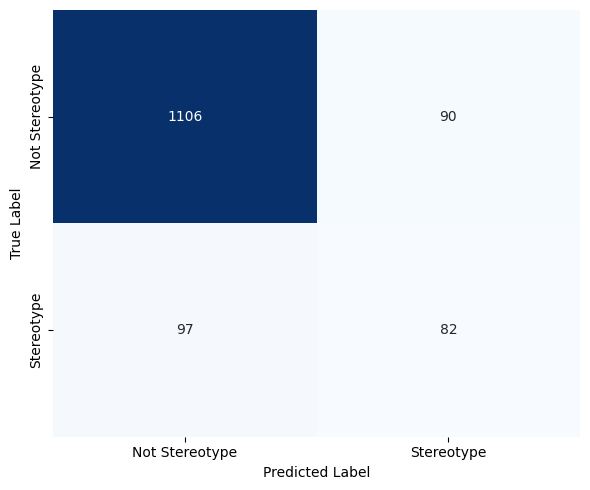

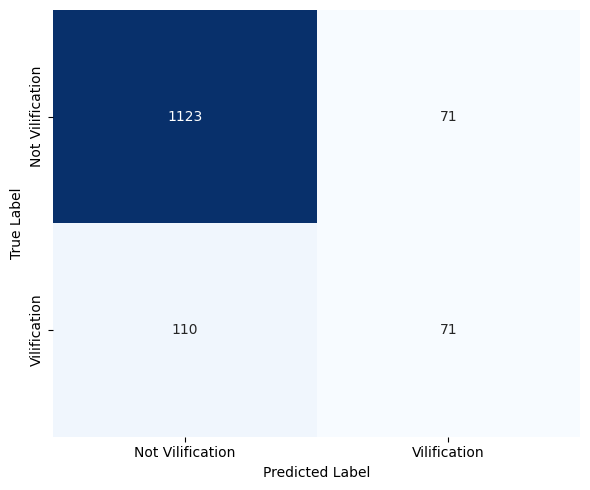

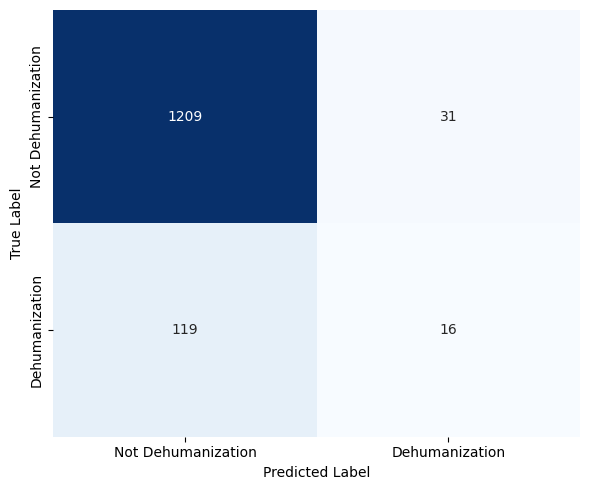

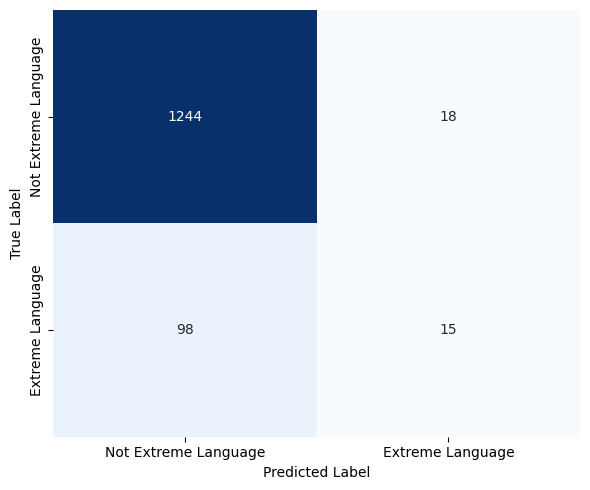

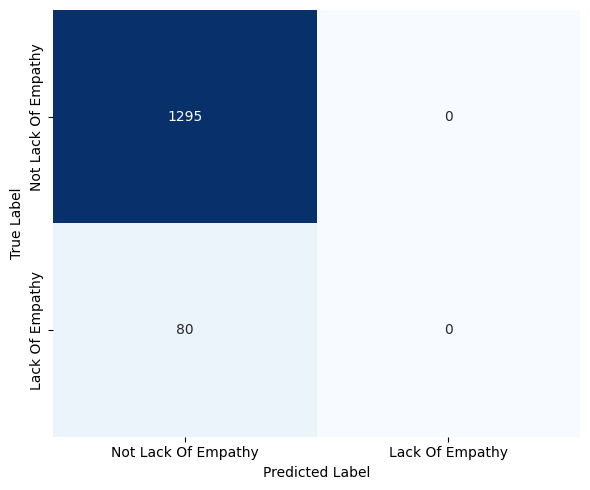

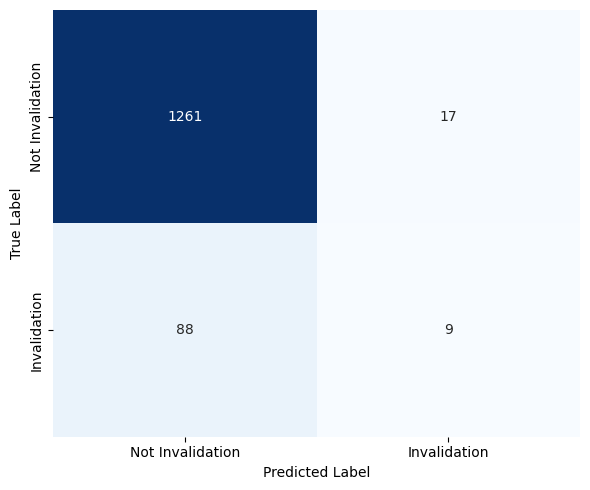

In [ ]:
val_predictions_subtask3 = trainer.predict(val_dataset)

probs_subtask3 = torch.sigmoid(torch.from_numpy(val_predictions_subtask3.predictions[0]))
predicted_labels_subtask3 = (probs_subtask3 > 0.5).int().numpy()

true_labels_subtask3 = np.array(val_dataset.labels)

label_columns_subtask3 = ['stereotype',
                          'vilification',
                          'dehumanization',
                          'extreme_language',
                          'lack_of_empathy',
                          'invalidation'
                          ]

# Create the directory if it doesn't exist
output_dir_confusion_matrices = '/content/drive/MyDrive/polar/confusion_matrices_task_3'
os.makedirs(output_dir_confusion_matrices, exist_ok=True)

for i, label_name in enumerate(label_columns_subtask3):
    cm = confusion_matrix(true_labels_subtask3[:, i], predicted_labels_subtask3[:, i])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Not {label_name.replace("_", " ").title()}',
                             label_name.replace("_", " ").title()],
                yticklabels=[f'Not {label_name.replace("_", " ").title()}',
                             label_name.replace("_", " ").title()])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_confusion_matrices,
                             f'confusion_matrix_subtask3_{label_name.replace("/", "_")}.pdf'),
                format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

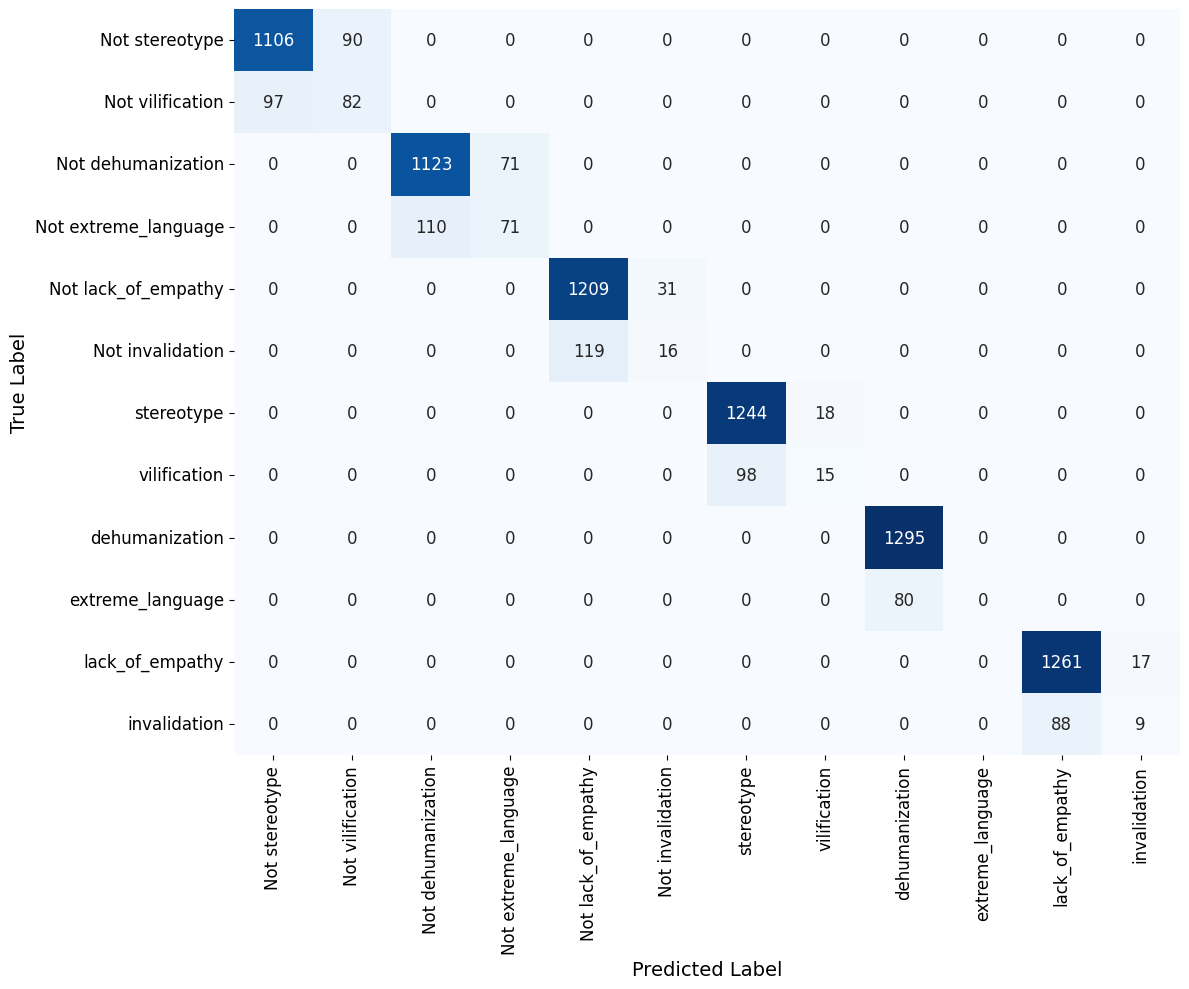

In [ ]:
val_predictions_subtask3 = trainer.predict(val_dataset)
probs_subtask3 = torch.sigmoid(torch.from_numpy(val_predictions_subtask3.predictions[0]))
predicted_labels_subtask3 = (probs_subtask3 > 0.5).int().numpy()
true_labels_subtask3 = np.array(val_dataset.labels)

label_columns_subtask3 = ['stereotype', 'vilification', 'dehumanization',
                          'extreme_language', 'lack_of_empathy', 'invalidation']

output_dir_confusion_matrices = '/content/drive/MyDrive/polar'
os.makedirs(output_dir_confusion_matrices, exist_ok=True)

# Initialize combined confusion matrix with integer type
combined_cm = np.zeros((len(label_columns_subtask3) * 2, len(label_columns_subtask3) * 2), dtype=int)

# Populate the combined confusion matrix
for i, label_name in enumerate(label_columns_subtask3):
    cm = confusion_matrix(true_labels_subtask3[:, i], predicted_labels_subtask3[:, i])

    # Fill in the combined confusion matrix
    combined_cm[i * 2:i * 2 + 2, i * 2:i * 2 + 2] = cm

# Plotting the combined confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Not {name}' for name in label_columns_subtask3] + label_columns_subtask3,
            yticklabels=[f'Not {name}' for name in label_columns_subtask3] + label_columns_subtask3,
            annot_kws={"fontsize":12})

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_confusion_matrices,
                         'combined_confusion_matrix_subtask3.pdf'),
            format='pdf', bbox_inches='tight')
plt.show()

## Make predictions

In [ ]:
eng_dev_3_dataset = PolarizationDataset(eng_dev_3['text'].tolist(), tokenizer)
hau_dev_3_dataset = PolarizationDataset(hau_dev_3['text'].tolist(), tokenizer)

output_dir_subtask3 = 'subtask_3'
os.makedirs(output_dir_subtask3, exist_ok=True)

original_label_order_in_preds = ['vilification',
                                 'extreme_language',
                                 'stereotype',
                                 'invalidation',
                                 'lack_of_empathy',
                                 'dehumanization'
                                 ]

desired_output_label_order = ['stereotype',
                              'vilification',
                              'dehumanization',
                              'extreme_language',
                              'lack_of_empathy',
                              'invalidation'
                              ]

label_to_pred_index = {name: original_label_order_in_preds.index(name) for name in original_label_order_in_preds}

# --- Generate predictions for English ---
print("Generating predictions for English (Subtask 3)...")
predictions_eng_3 = trainer.predict(eng_dev_3_dataset)
probs_eng_3 = torch.sigmoid(torch.from_numpy(predictions_eng_3.predictions[0]))
predicted_labels_eng_3 = (probs_eng_3 > 0.5).int().numpy()
ids_eng_3 = eng_dev_3['id'].tolist()

submission_df_eng_3 = pd.DataFrame({'id': ids_eng_3})
for col_name in desired_output_label_order:
    pred_idx = label_to_pred_index[col_name]
    submission_df_eng_3[col_name] = predicted_labels_eng_3[:, pred_idx]

output_filename_eng_3 = os.path.join(output_dir_subtask3, 'pred_eng.csv')
submission_df_eng_3.to_csv(output_filename_eng_3, index=False)

print(f"English (Subtask 3) predictions saved to {output_filename_eng_3}")
print(submission_df_eng_3.head())

# --- Generate predictions for Hausa ---
print("Generating predictions for Hausa (Subtask 3)...")
predictions_hau_3 = trainer.predict(hau_dev_3_dataset)
probs_hau_3 = torch.sigmoid(torch.from_numpy(predictions_hau_3.predictions[0]))
predicted_labels_hau_3 = (probs_hau_3 > 0.5).int().numpy()
ids_hau_3 = hau_dev_3['id'].tolist()

submission_df_hau_3 = pd.DataFrame({'id': ids_hau_3})
for col_name in desired_output_label_order:
    pred_idx = label_to_pred_index[col_name]
    submission_df_hau_3[col_name] = predicted_labels_hau_3[:, pred_idx]

output_filename_hau_3 = os.path.join(output_dir_subtask3, 'pred_hau.csv')
submission_df_hau_3.to_csv(output_filename_hau_3, index=False)

print(f"Hausa (Subtask 3) predictions saved to {output_filename_hau_3}")
print(submission_df_hau_3.head())

In [ ]:
!cd /content && zip -r /content/subtask_3.zip subtask_3
files.download("/content/subtask_3.zip")